https://www.kaggle.com/code/robertoganyan/0-85365-baseline-advanced-stacking

Plan of notebook:

1.Imports & Downloading

2.Exploratory Data Analysis

3.Baseline

3.1.Preprocessing

3.2. Adversarial Validation

3.3. CatBoost

3.4. Torch NN

4.Advanced

4.1. Missing values

4.2. Feature engineering

4.3. Ensemble of models aka `Stacking`

As for baseline, best public score was 0.75.

As for advanced, best public score was 0.85365, but without paragraph 4.2 and with some different hyperparams

## 1.Imports & Downloading

In [1]:
import numpy as np 
import pandas as pd 
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import cv

import catboost as cb
from xgboost import plot_importance
from copy import deepcopy
from sklearn.model_selection import GridSearchCV

from sklearn.preprocessing import LabelEncoder, OneHotEncoder

from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from tqdm.notebook import tqdm
import torch
import torch.nn as nn
from torch.optim import Adam
import torch.nn.functional as F
from torch.utils.data import WeightedRandomSampler
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold

from sklearn.ensemble import (RandomForestClassifier, HistGradientBoostingClassifier,
                              GradientBoostingClassifier,ExtraTreesClassifier, AdaBoostClassifier)

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
import lightgbm as lgb
from sklearn.preprocessing import StandardScaler

from collections import defaultdict
from sklearn.gaussian_process.kernels import RBF
import warnings
from sklearn.preprocessing import PolynomialFeatures
from scipy import stats
from sklearn.inspection import permutation_importance
from sklearn.metrics import make_scorer



/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
!pip install --upgrade tqdm

In [3]:
os.listdir('/kaggle/input')

['horse-survival-dataset', 'playground-series-s3e22']

`train_df, test_df` - synthetic data, `original_df` - real-world data

In [4]:
train_df = pd.read_csv('/kaggle/input/playground-series-s3e22/train.csv')
test_df = pd.read_csv('/kaggle/input/playground-series-s3e22/test.csv')
sample_df = pd.read_csv('/kaggle/input/playground-series-s3e22/sample_submission.csv')
original_df = pd.read_csv('/kaggle/input/horse-survival-dataset/horse.csv')

In [5]:
train_df =  train_df.drop(['id'], axis=1)
test_df = test_df.drop(['id'], axis=1)

In [6]:
assert set(original_df.columns) == set(train_df.columns)

Making the column order of synthetic and real data the same

In [7]:
original_df = original_df[train_df.columns]

In [8]:
train_df['generated'] = True
original_df['generated'] = False
test_df['generated'] = True

train_df['generated'] = train_df['generated'].astype(object)
original_df['generated'] = original_df['generated'].astype(object)
test_df['generated'] = test_df['generated'].astype(object)

In [9]:
new_train_df = pd.concat([train_df, original_df]).sample(frac=1)
new_train_df.head(5)

surgery    age  hospital_number  rectal_temp  pulse  respiratory_rate  \
192      no  adult           528179         38.2   42.0              14.0   
892     yes  young          5290409         37.2  150.0              80.0   
255     yes  adult           533871         37.5   72.0               NaN   
181     yes  adult          5287179         38.5   72.0              40.0   
253     yes  adult           535031         37.5   60.0              48.0   

    temp_of_extremities peripheral_pulse mucous_membrane  \
192                cool           normal     normal_pink   
892                cool          reduced   dark_cyanotic   
255                warm           normal     normal_pink   
181                cool          reduced   pale_cyanotic   
253                cool          reduced      bright_red   

    capillary_refill_time  ... total_protein abdomo_appearance abdomo_protein  \
192            less_3_sec  ...           6.6            cloudy            4.1   
892            more_3_sec  ...           7.5     serosanguious            5.3   
255            less_3_sec  ...          65.0            cloudy            2.0   
181            less_3_sec  ...           8.5     serosanguious            4.4   
253            more_3_sec  ...          81.0            cloudy            2.0   

    surgical_lesion lesion_1  lesion_2 lesion_3 cp_data     outcome  generated  
192             yes     2206         0        0     yes       lived       True  
892             yes     2205         0        0     yes        died       True  
255             yes     7209         0        0      no  euthanized      False  
181             yes     2206         0        0     yes       lived       True  
253             yes     2322         0        0      no       lived       True  

[5 rows x 29 columns]

In [10]:
assert len(new_train_df) == len(train_df) + len(original_df)
len(new_train_df)

1534

In [11]:
new_train_df.drop_duplicates(inplace=True)
len(new_train_df)

1534

## 2. Exploratory Data Analysis

In `seaborn` there is a useful function `pairplot`, but the results of it are not clearly visible. So we'll implement our own functions

/opt/conda/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


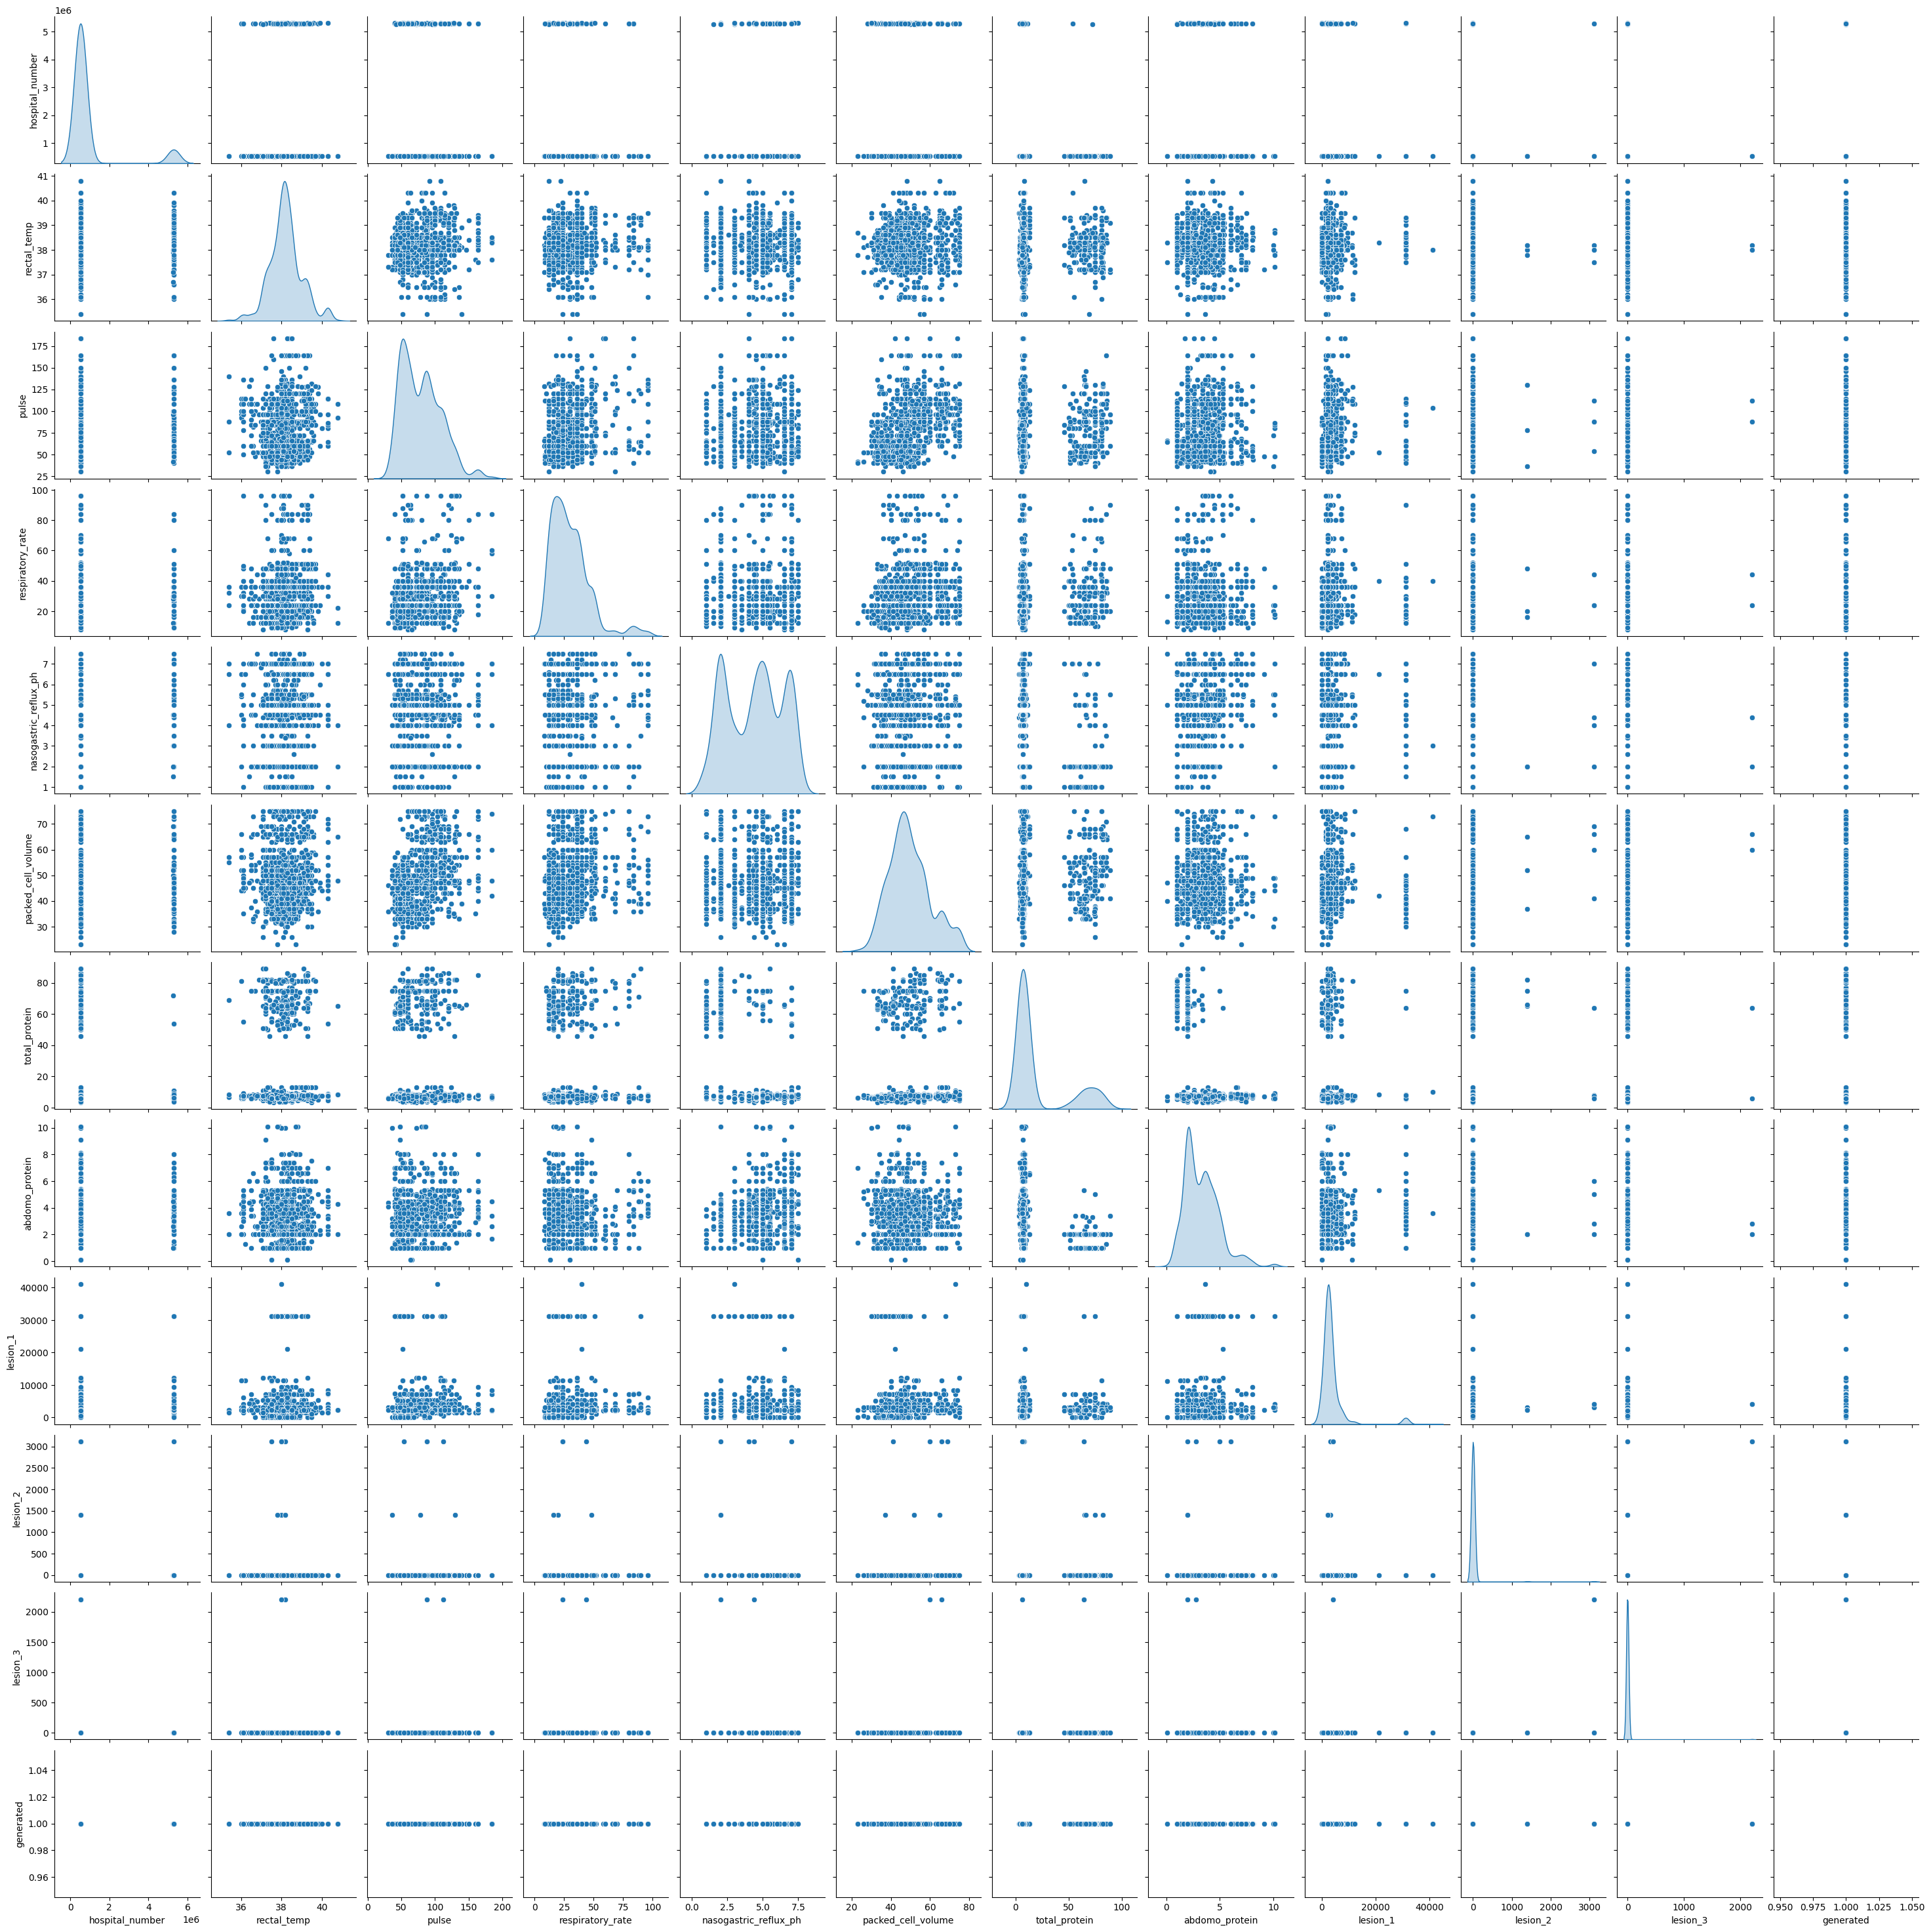

In [12]:
sns.pairplot(train_df, diag_kind="kde")

At first lets define numerical and categorical features

In [13]:
numeric_features = []
categorical_features = []
for col in new_train_df.columns:
    if new_train_df[col].dtype == object:
        categorical_features.append(col)
    else:
        numeric_features.append(col)    

In [14]:
train_df[numeric_features].head(2)

hospital_number  rectal_temp  pulse  respiratory_rate  \
0           530001         38.1  132.0              24.0   
1           533836         37.5   88.0              12.0   

   nasogastric_reflux_ph  packed_cell_volume  total_protein  abdomo_protein  \
0                    6.5                57.0            8.5             3.4   
1                    2.0                33.0           64.0             2.0   

   lesion_1  lesion_2  lesion_3  
0      2209         0         0  
1      2208         0         0

`hospital_number` is yet categorical. We leave the lists of features as they are for now, but we'll change them in the future.

In [15]:
def custom_plot0(plot_func, train, test, orig, columns, name, *args, **kwargs):
    fig, axs = plt.subplots(len(columns), 1, figsize = (10,20))
    fig.suptitle(f'{name}' + ' features \n', fontsize = 20)
    
    for i, col in enumerate(columns):
        plot_func(data=train[col], ax=axs[i], color = 'r', *args, **kwargs)
        plot_func(data=test[col], ax=axs[i], color = 'g', *args, **kwargs)
        plot_func(data=orig[col], ax=axs[i], color = 'b', *args, **kwargs)
        
        axs[i].set_title(f'{name} {col}')
    fig.legend(['Train_generated', 'Test_generated', 'Train_original'])
        
    plt.tight_layout()

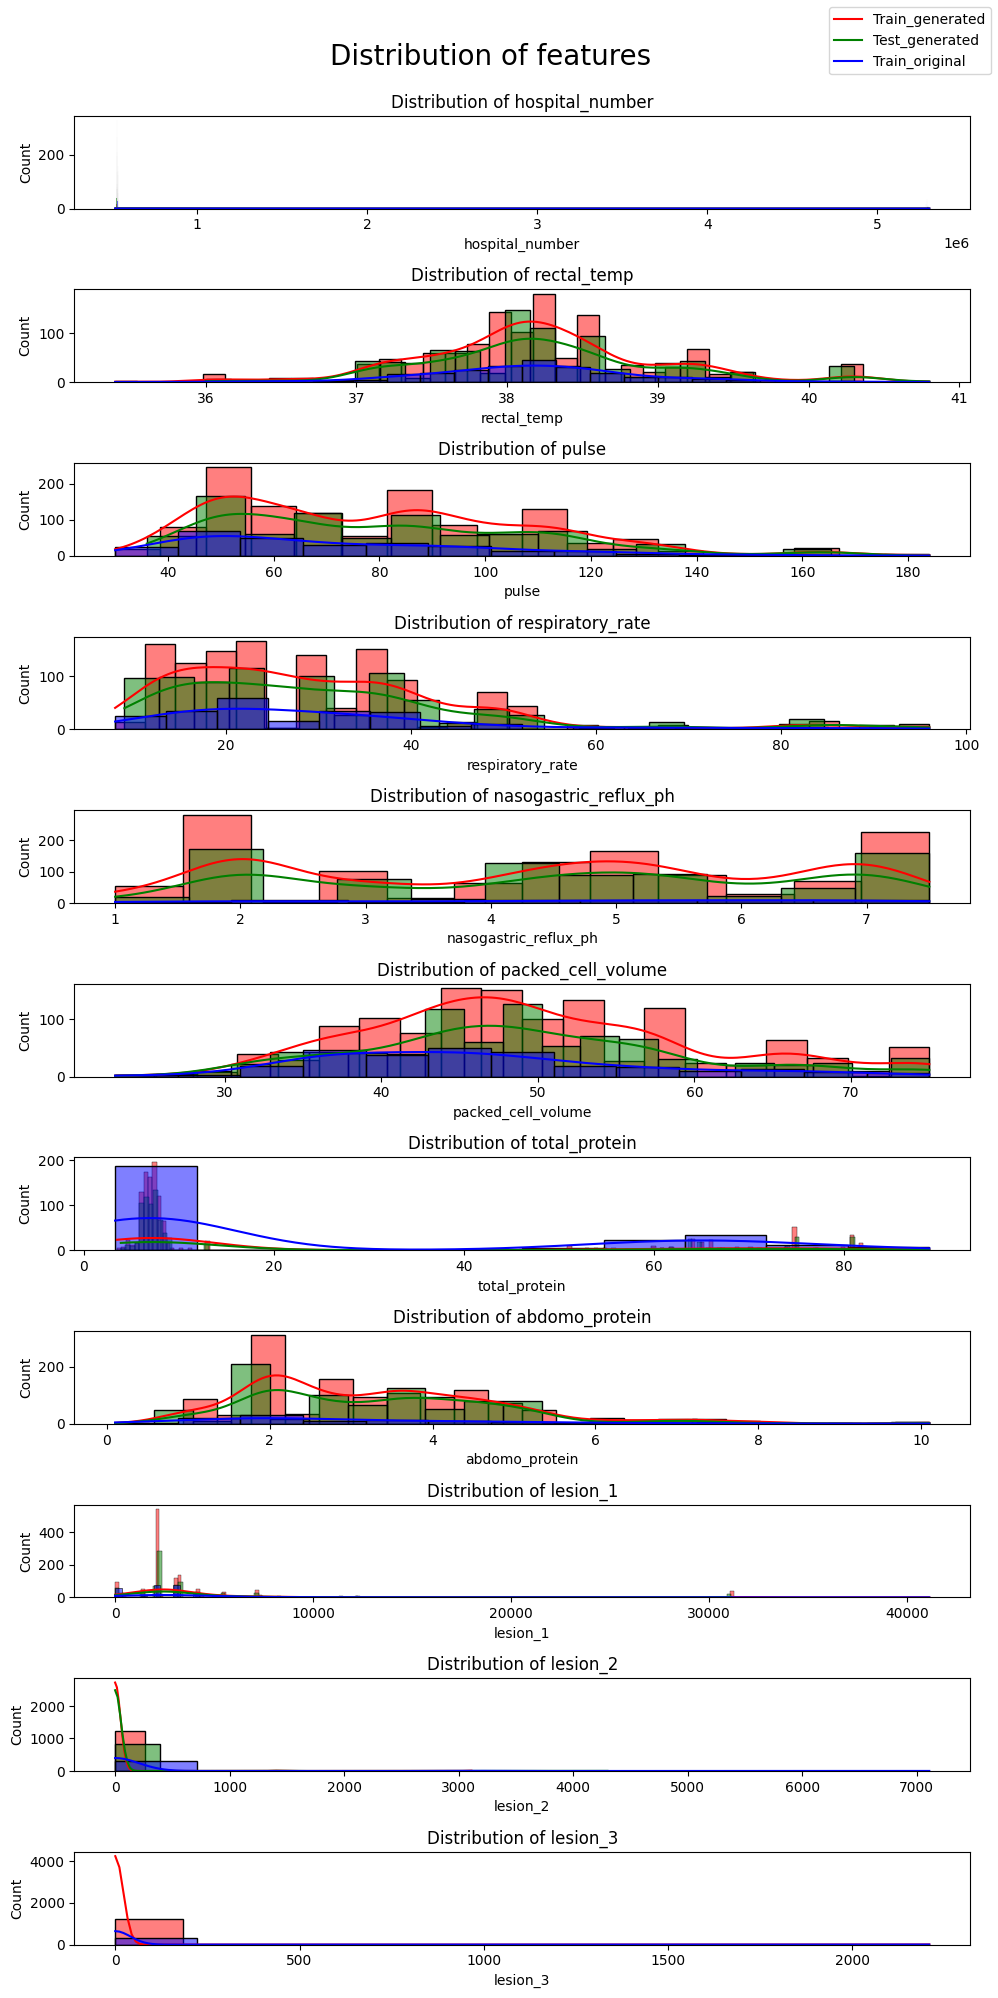

In [16]:
custom_plot0(sns.histplot, train_df, test_df, original_df, numeric_features, 'Distribution of', kde=True)

What can we say about the distribution graphs of numerical characteristics:
1. Distributions of train and test data are the same
2. `total_protein` seems to have different distributions, but the reason is a rough binarization of floats

In [17]:
def custom_plot1(train, orig, columns, name, names, *args, **kwargs):
    fig, axs = plt.subplots(len(columns), 2, figsize = (20,30))
    fig.suptitle(f'{name}' + ' features \n', fontsize = 20)
    
    for i, col in enumerate(columns):
        sns.kdeplot(data=train, ax=axs[i][0], x = col, *args, **kwargs)
        sns.kdeplot(data=orig, ax=axs[i][1], x = col, *args, **kwargs)
              
    for ax, col in zip(axs[0], names):
        ax.set_title(col)

    for ax, row in zip(axs[:,0], columns):
        ax.set_ylabel(row, rotation=90, size='large')
        
    for ax, row in zip(axs[:,1], columns):
        ax.set_ylabel('')
        
    plt.tight_layout()

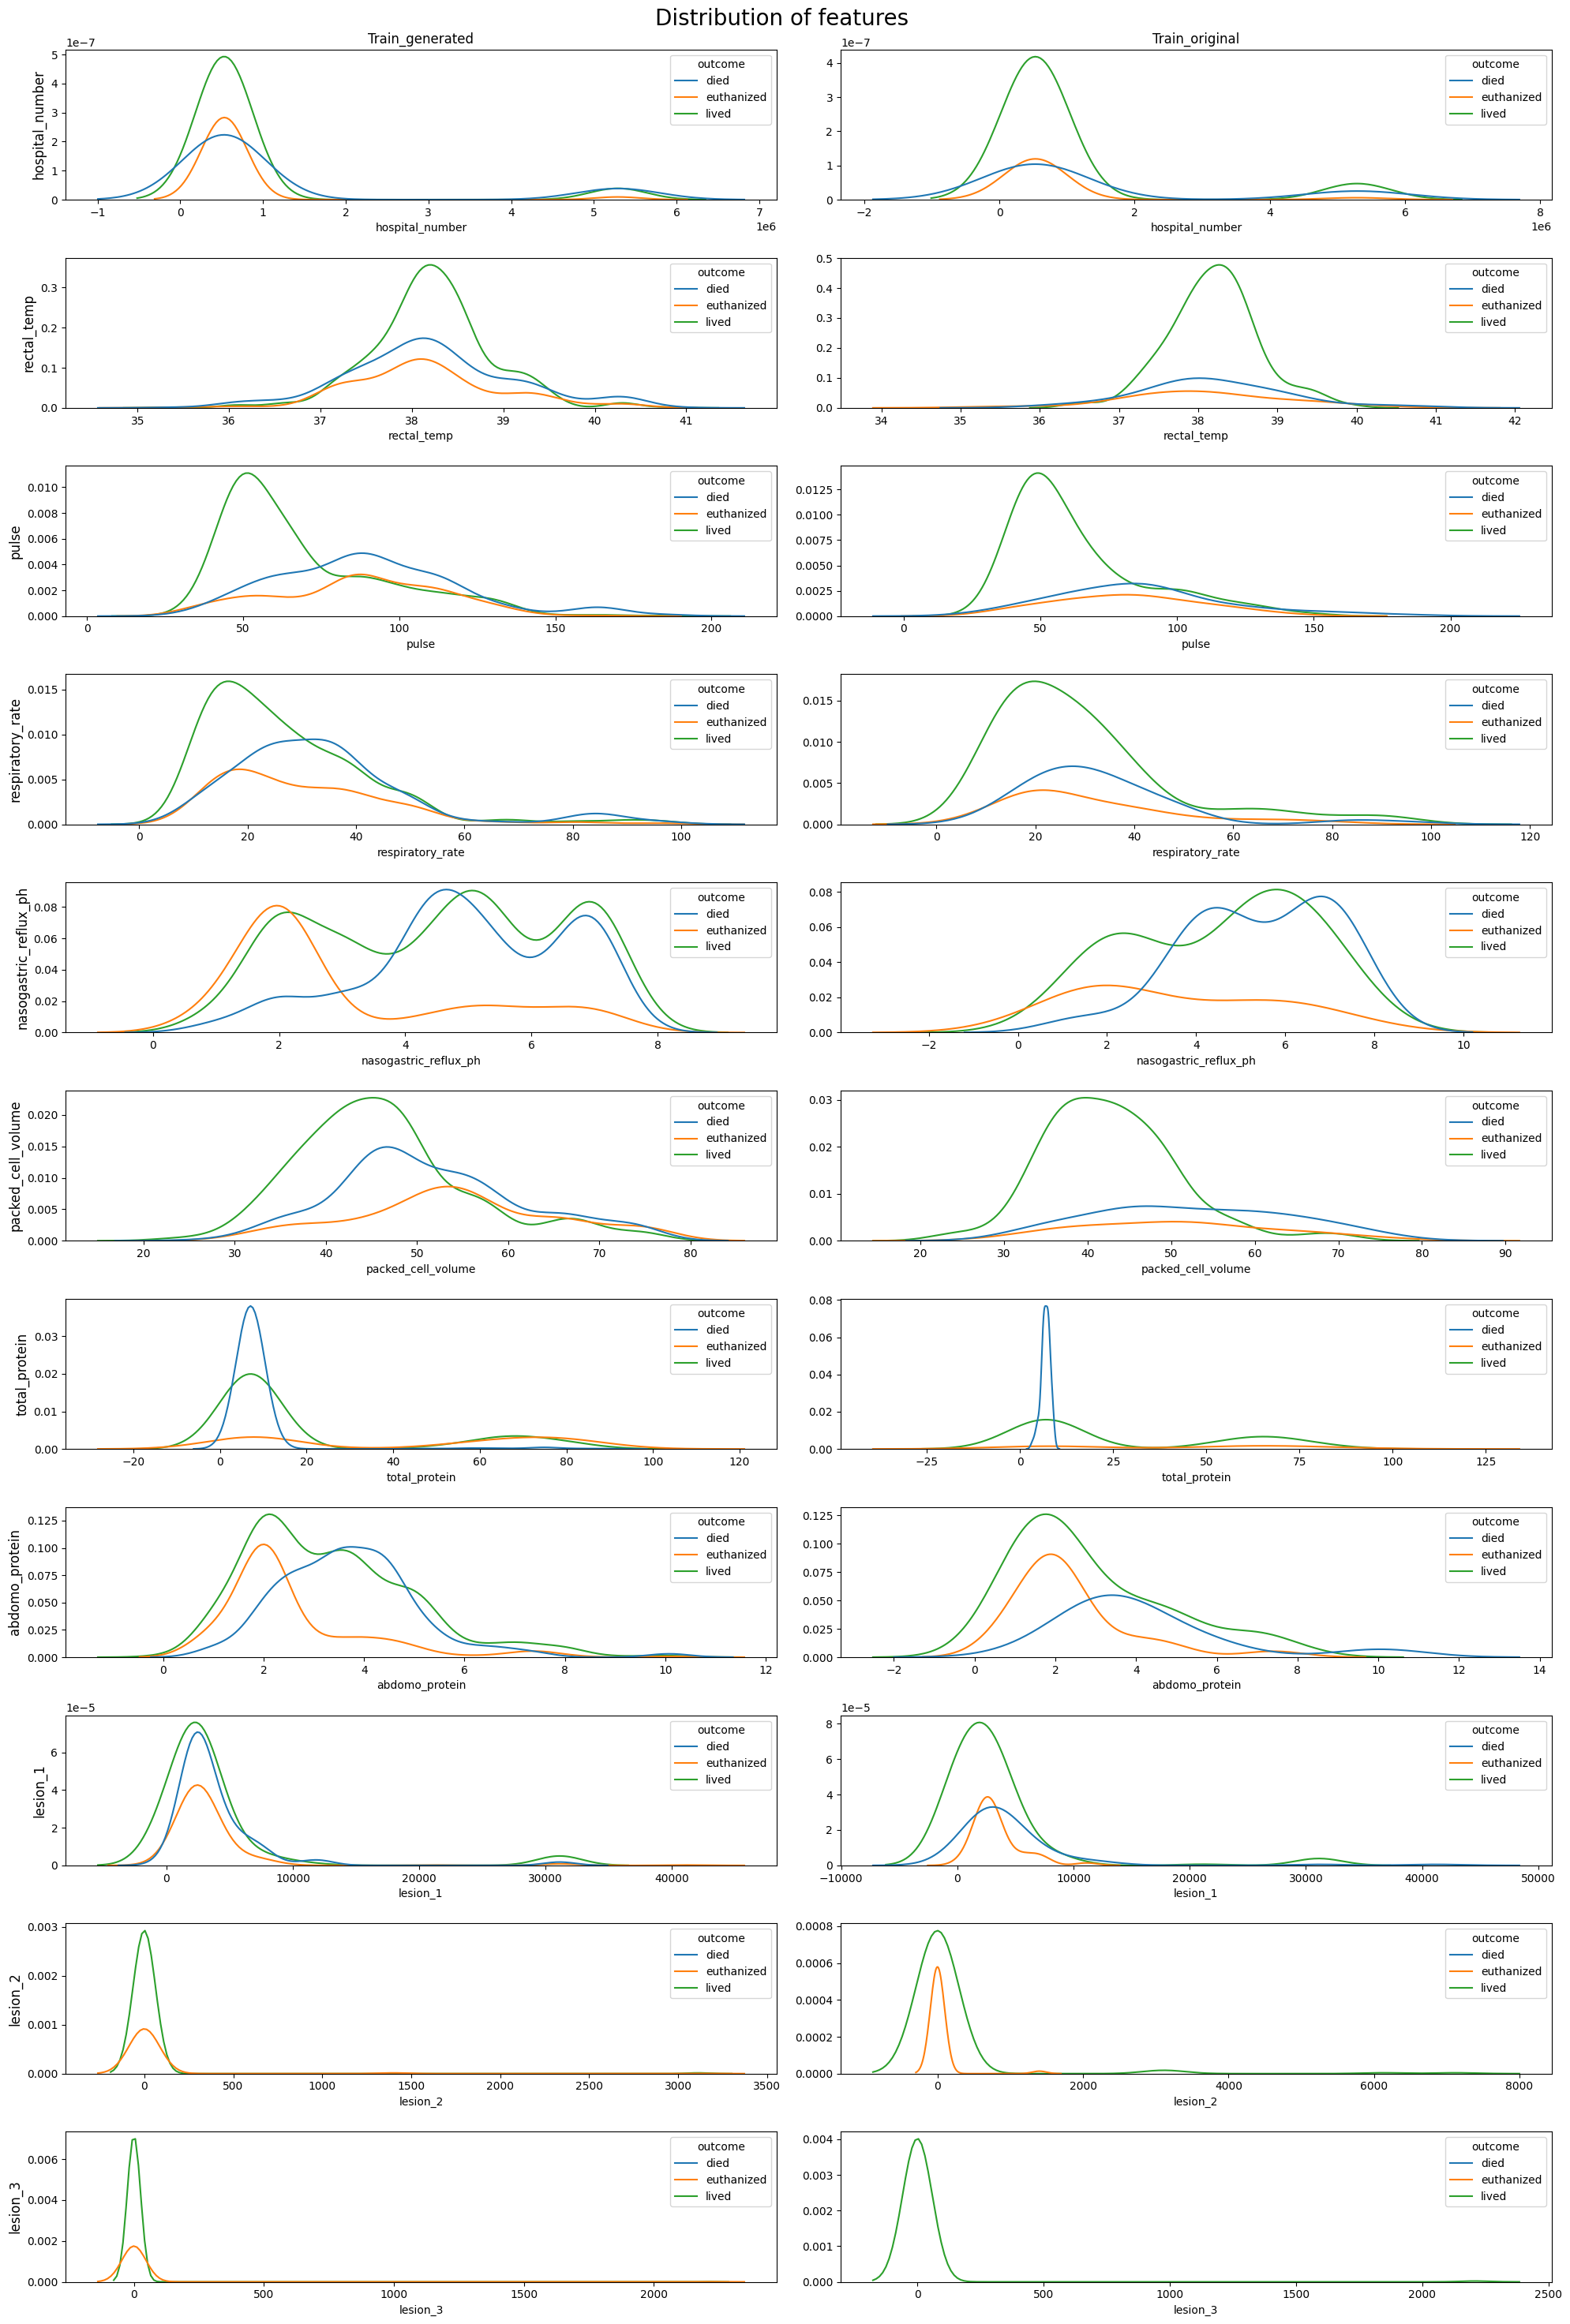

In [18]:
custom_plot1(train_df, original_df, numeric_features, 'Distribution of',names = ['Train_generated', 'Train_original'],
             warn_singular=False, hue='outcome')

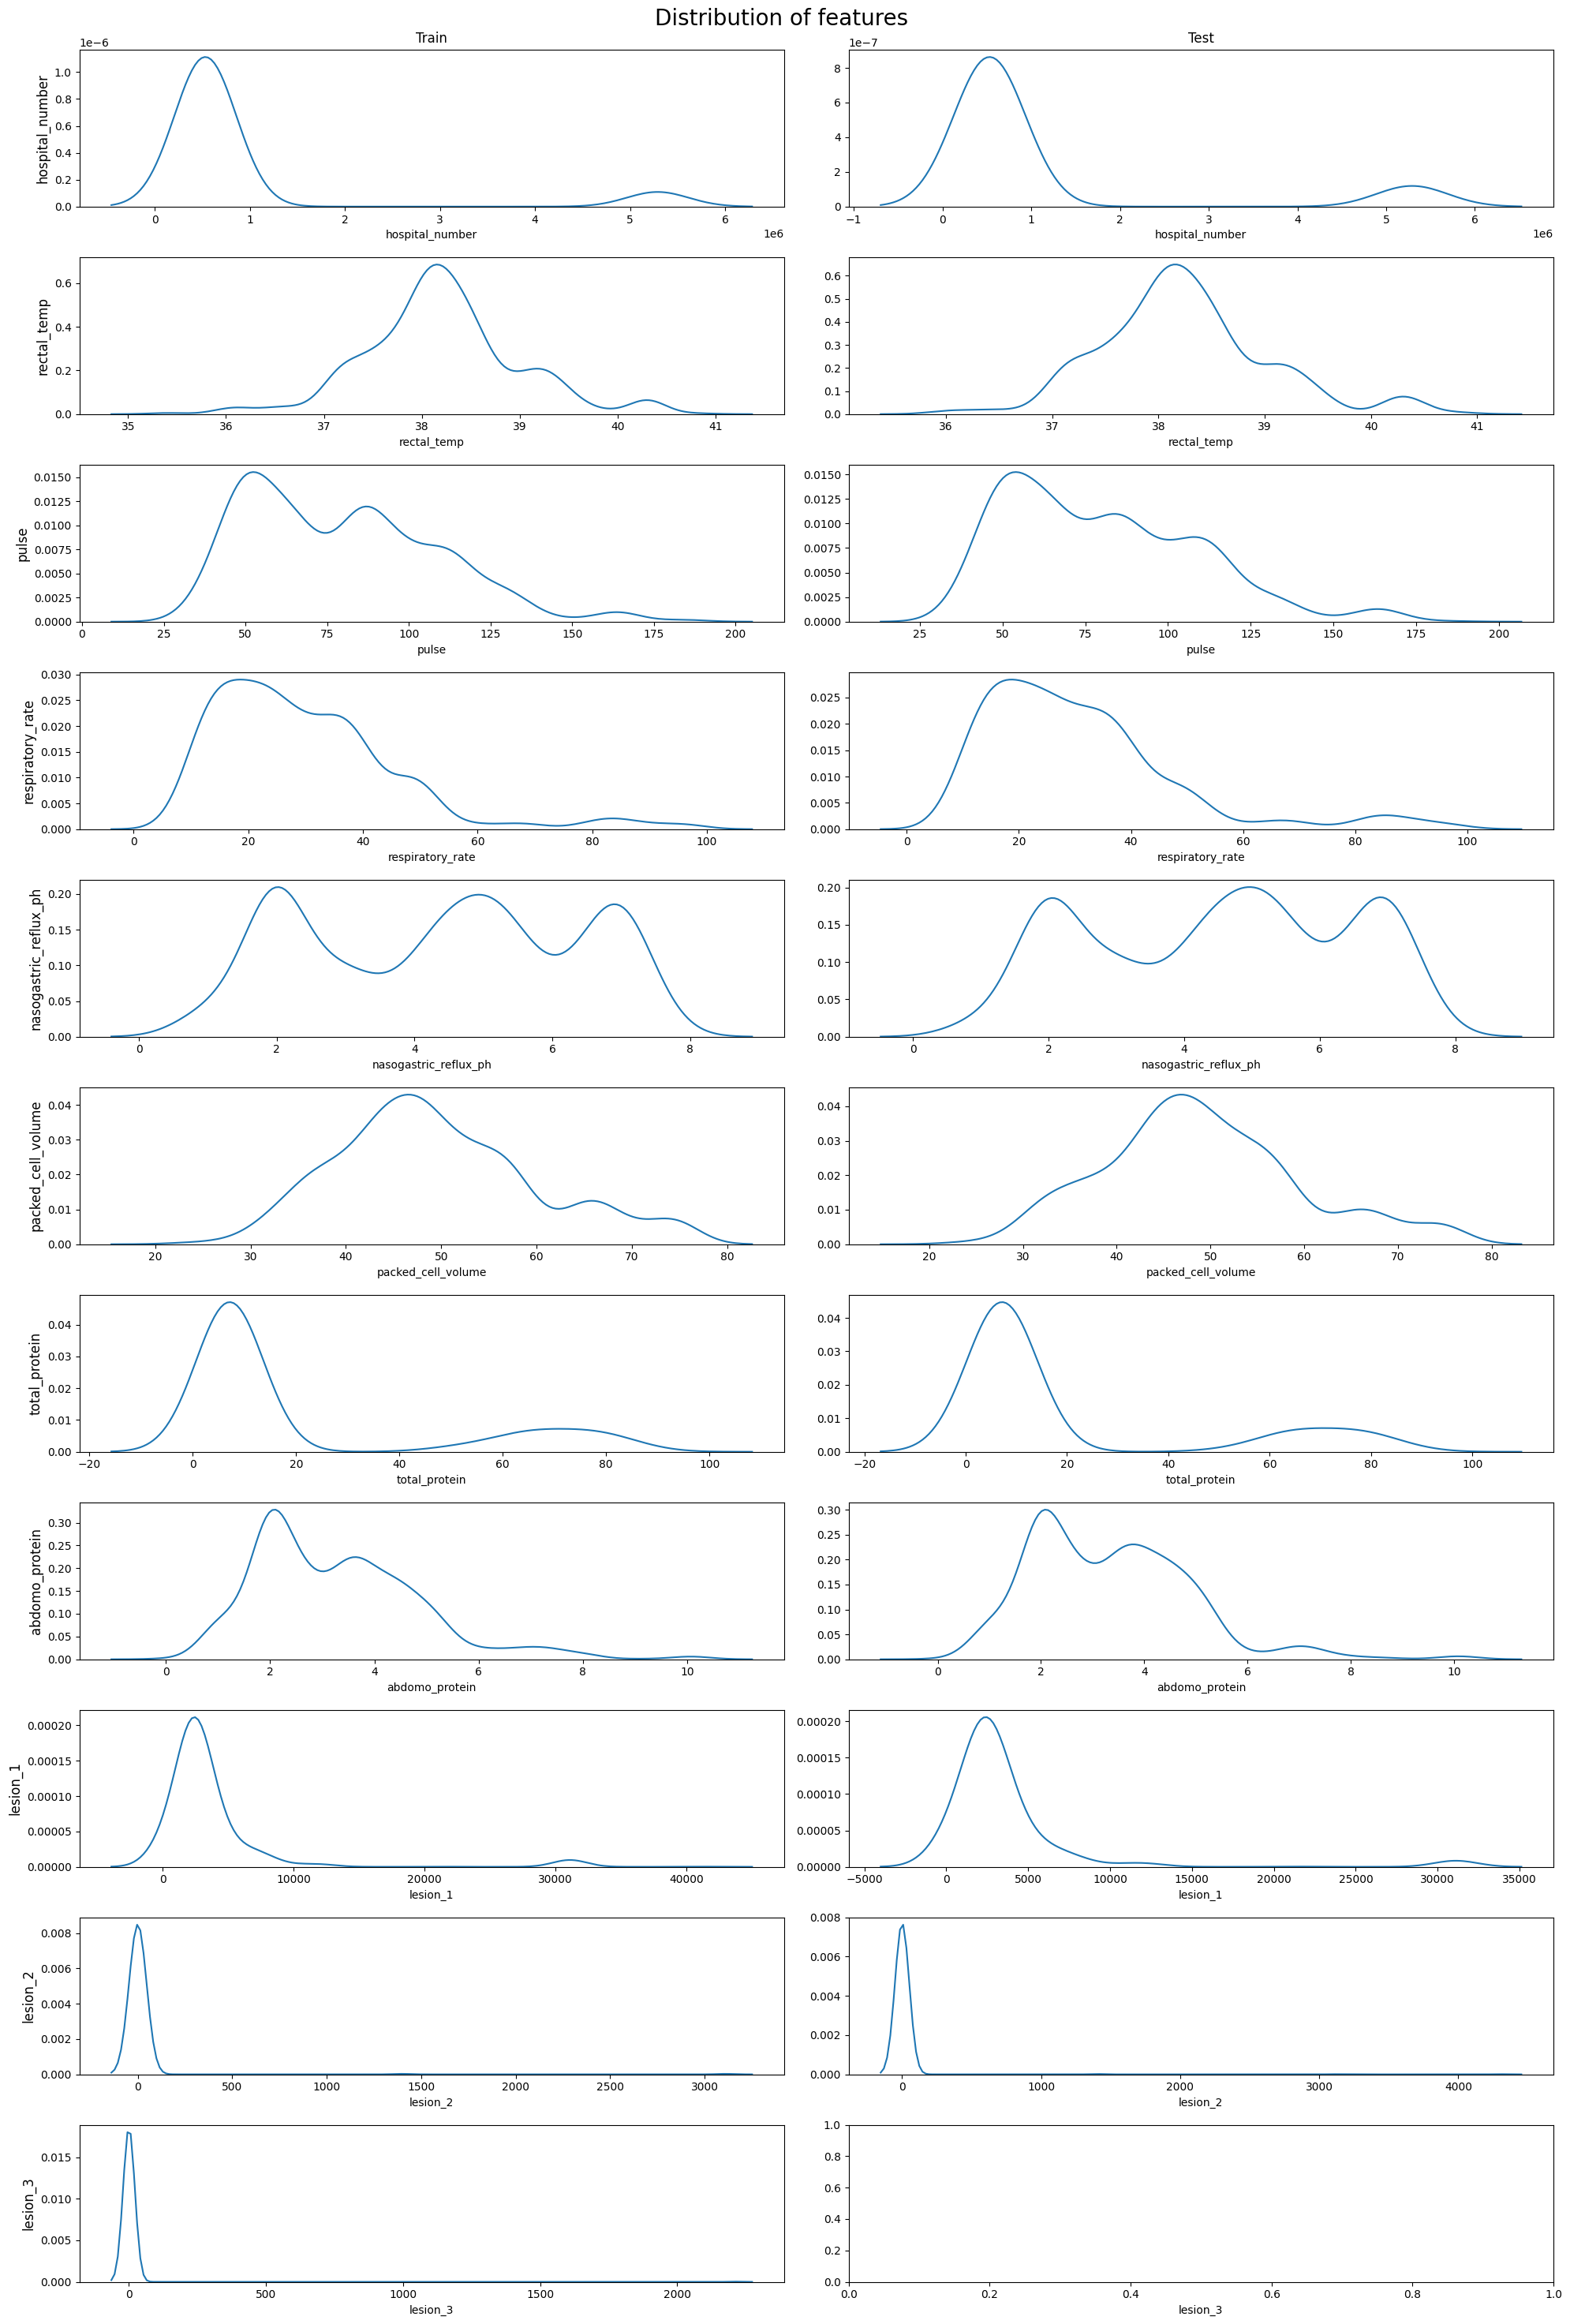

In [19]:
custom_plot1(train_df, test_df, numeric_features, 'Distribution of',
             names = ['Train', 'Test'],  
             warn_singular=False)

Still seems like distributions are the same. We'll make sure about it after doing adversarial validation later

In [20]:
def custom_plot2(plot_func, train, test, orig, columns, name, *args, **kwargs):
    fig, axs = plt.subplots(len(columns), 3, figsize = (10,20))
    fig.suptitle(f'{name}' + ' features \n', fontsize = 20)
    
    for i, col in enumerate(columns):
        plot_func(data=train[col], ax=axs[i][0], color = 'r', *args, **kwargs)
        plot_func(data=test[col], ax=axs[i][1], color = 'g', *args, **kwargs)
        plot_func(data=orig[col], ax=axs[i][2], color = 'b', *args, **kwargs)
        
    names = ['Train_generated', 'Test_generated', 'Train_original']        
    for ax, col in zip(axs[0], names):
        ax.set_title(col)

    for ax, row in zip(axs[:,0], columns):
        ax.set_ylabel(row, rotation=90, size='large')
        
    plt.tight_layout()

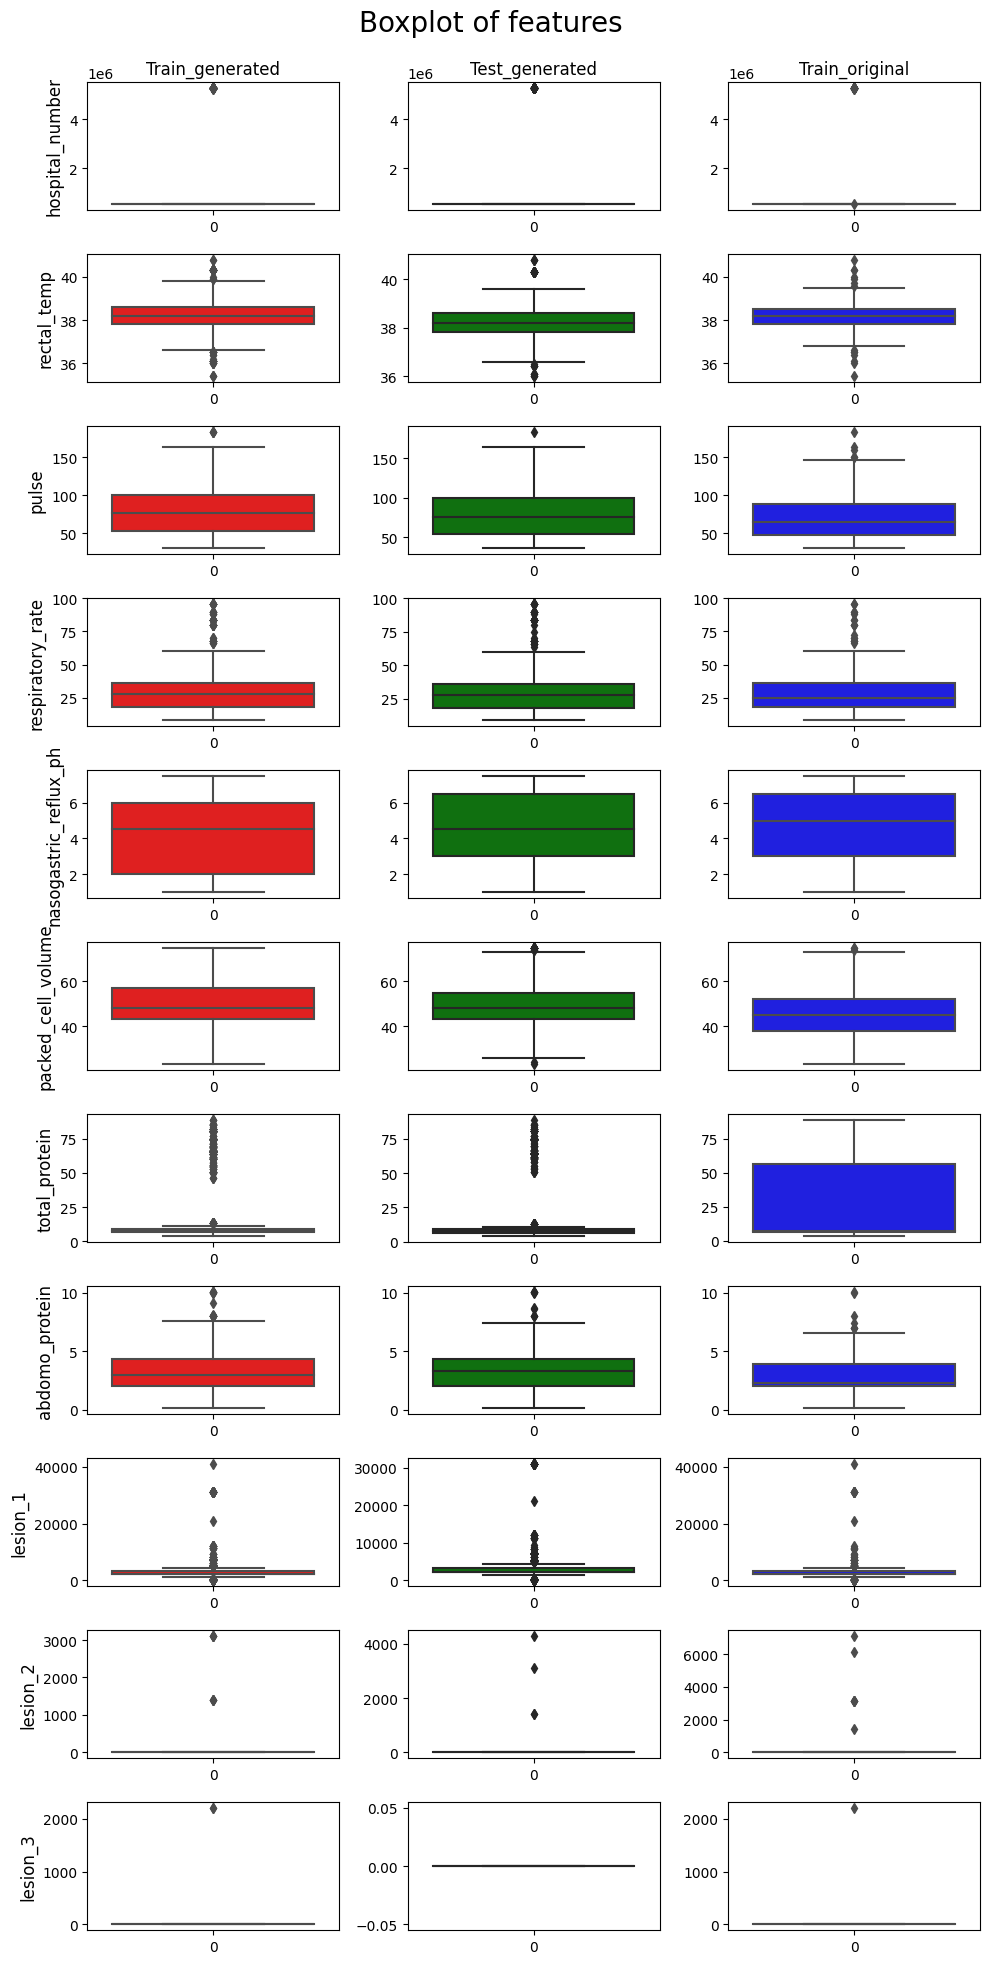

In [21]:
custom_plot2(sns.boxplot, train_df, test_df, original_df, numeric_features, 'Boxplot of')

Seems like boxplots found a lot of outliners, but at the same time we see that the distributions of train, test and original data are kinda similar. So those are probably not outliners and I won't risk to "process" them

Let's check `scatterplot` of features and target, perhaps we'll notice some kind of dependence. We check only `train`, because as we saw above, the distributions of different datasets are similar

In [22]:
def custom_plot3(plot_func, train, columns, name, *args, **kwargs):
    fig, axs = plt.subplots(len(columns), 1, figsize = (10,20))
    fig.suptitle(f'{name}' + ' features \n', fontsize = 20)
    
    for i, col in enumerate(columns):
        
        plot_func(data=train, ax=axs[i],x = col, y = 'outcome', color = 'b', *args, **kwargs)
        
        axs[i].set_title(f'{name} {col}')
        
    plt.tight_layout()

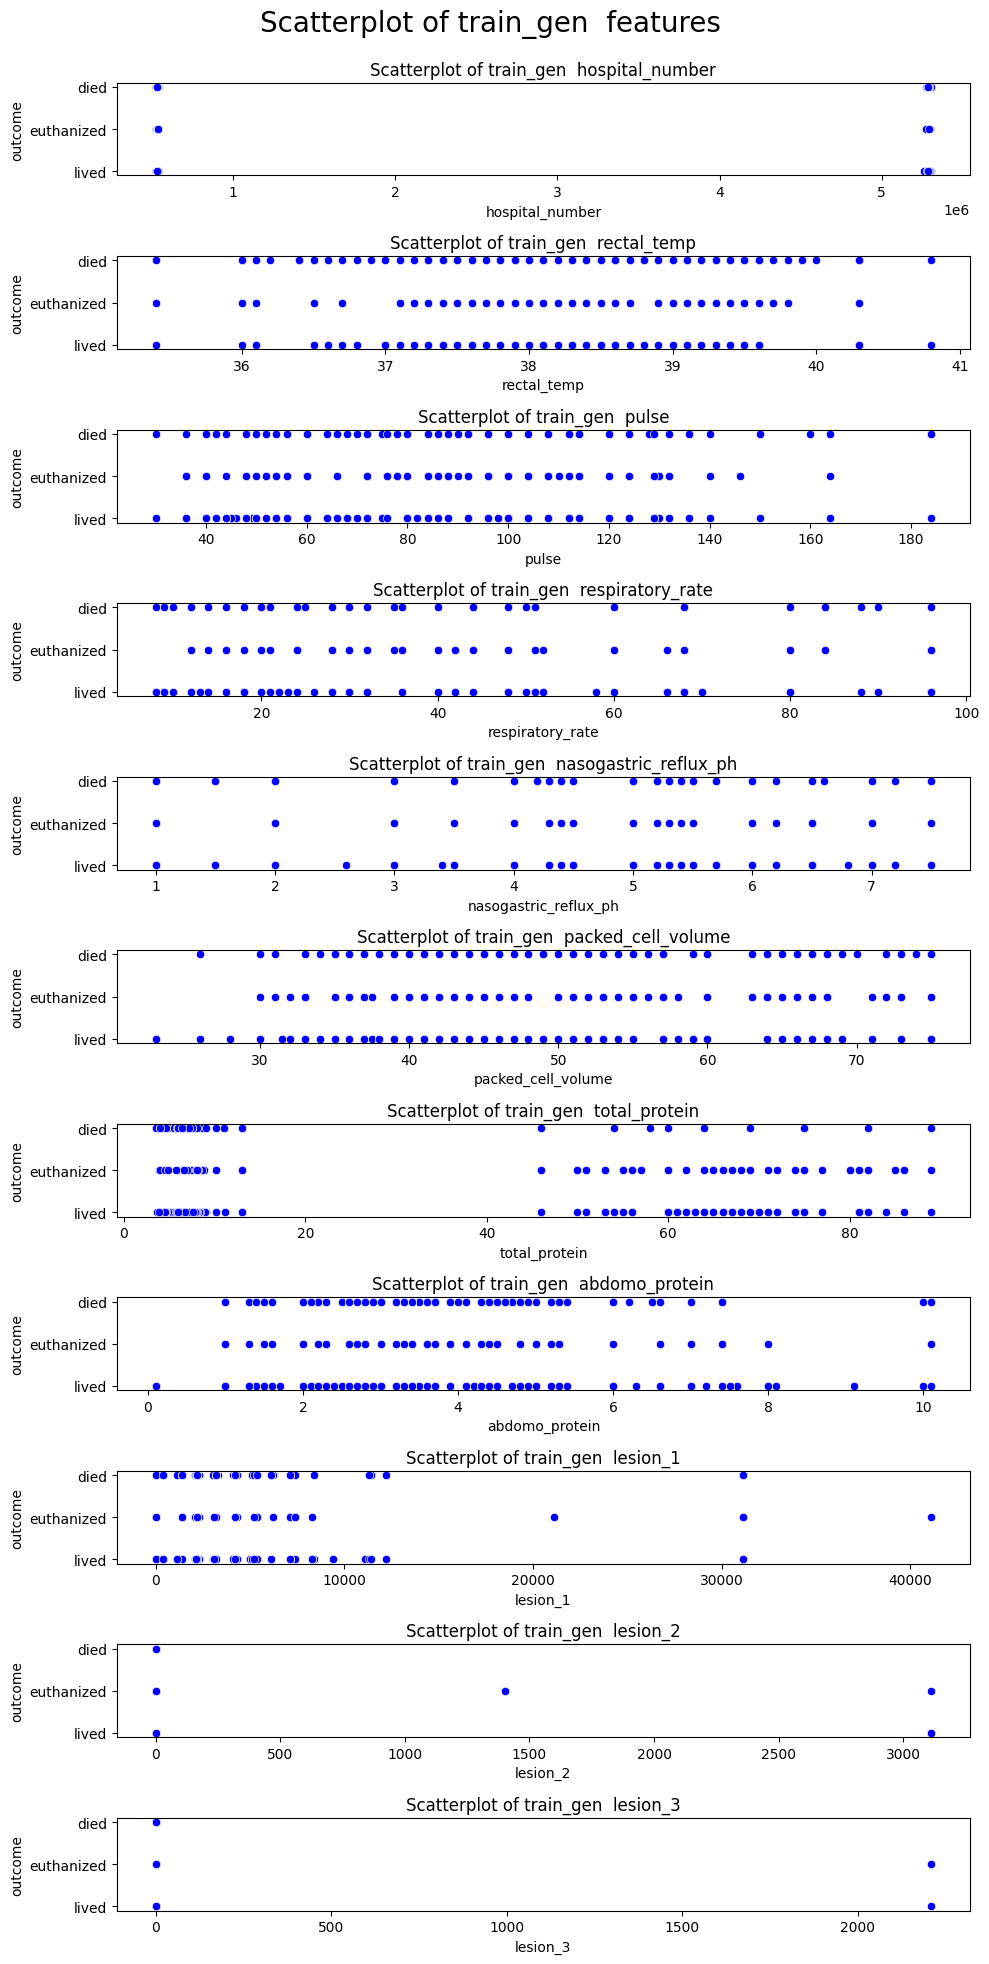

In [23]:
custom_plot3(sns.scatterplot, train_df, numeric_features, 'Scatterplot of train_gen ')

We did not get any useful information. What about linear dependence (Pearson correlation coefficient)?

<Axes: >

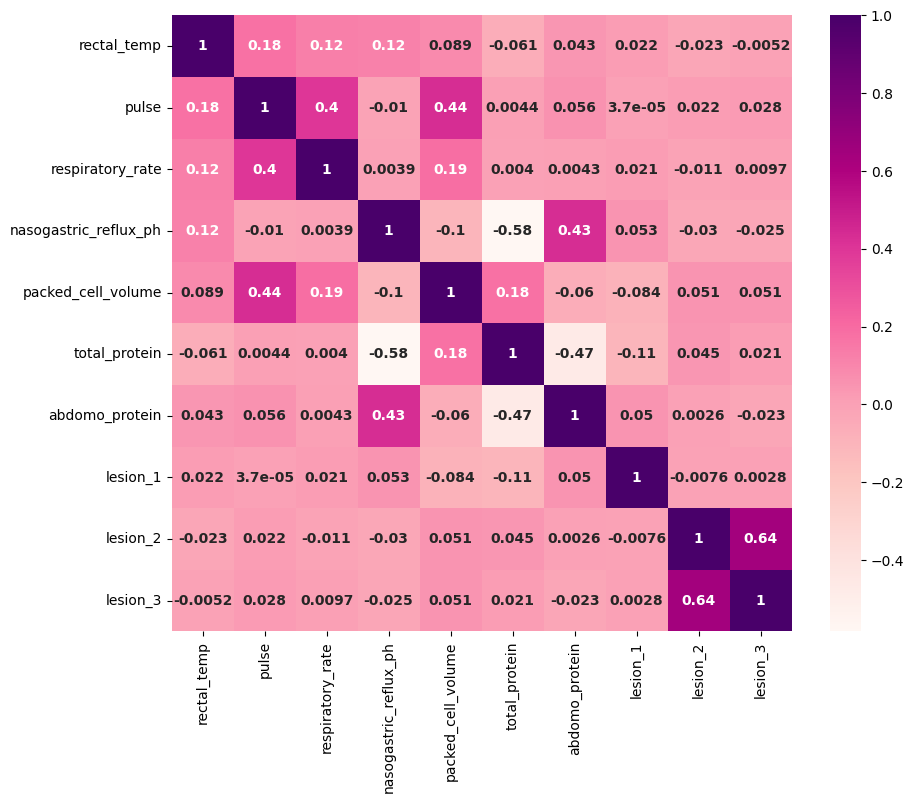

In [24]:
corr_fi = train_df[numeric_features[1:]].corr() # no hospital_number
fig = plt.figure(figsize=(10, 8))
sns.heatmap(corr_fi,
            xticklabels = corr_fi.columns,
            yticklabels = corr_fi.columns,
            annot = True,
            cmap="RdPu",
            annot_kws={"weight":"bold"})

Don't have any linear dependence between numerical features

What about categorical features?

In [25]:
def custom_plot4(train, test, orig, columns, name, *args, **kwargs):
    fig, axs = plt.subplots(len(columns), 3, figsize = (15,40))
    fig.suptitle(f'{name}' + ' features \n \n \n', fontsize = 20)
    
    for i, col in enumerate(columns):
        axs[i][0].pie(train[col].value_counts(), labels =  train[col].value_counts().keys(),
                      shadow=True, *args, **kwargs)
        if col != 'outcome':
            axs[i][1].pie(test[col].value_counts(),labels =  test[col].value_counts().keys(),
                          shadow=True, *args, **kwargs)
        else:
            axs[i][1].pie(train[col].value_counts(), labels =  train[col].value_counts().keys(),
                          shadow=True, *args, **kwargs)
        axs[i][2].pie(orig[col].value_counts(),labels =  orig[col].value_counts().keys(),
                      shadow=True, *args, **kwargs)
        

    names = ['Train_generated', 'Test_generated', 'Train_original']        
    for ax, col in zip(axs[0], names):
        ax.set_title(col)

    for ax, row in zip(axs[:,0], columns):
        ax.set_ylabel(row, rotation=90, size='large')
        
    plt.tight_layout()

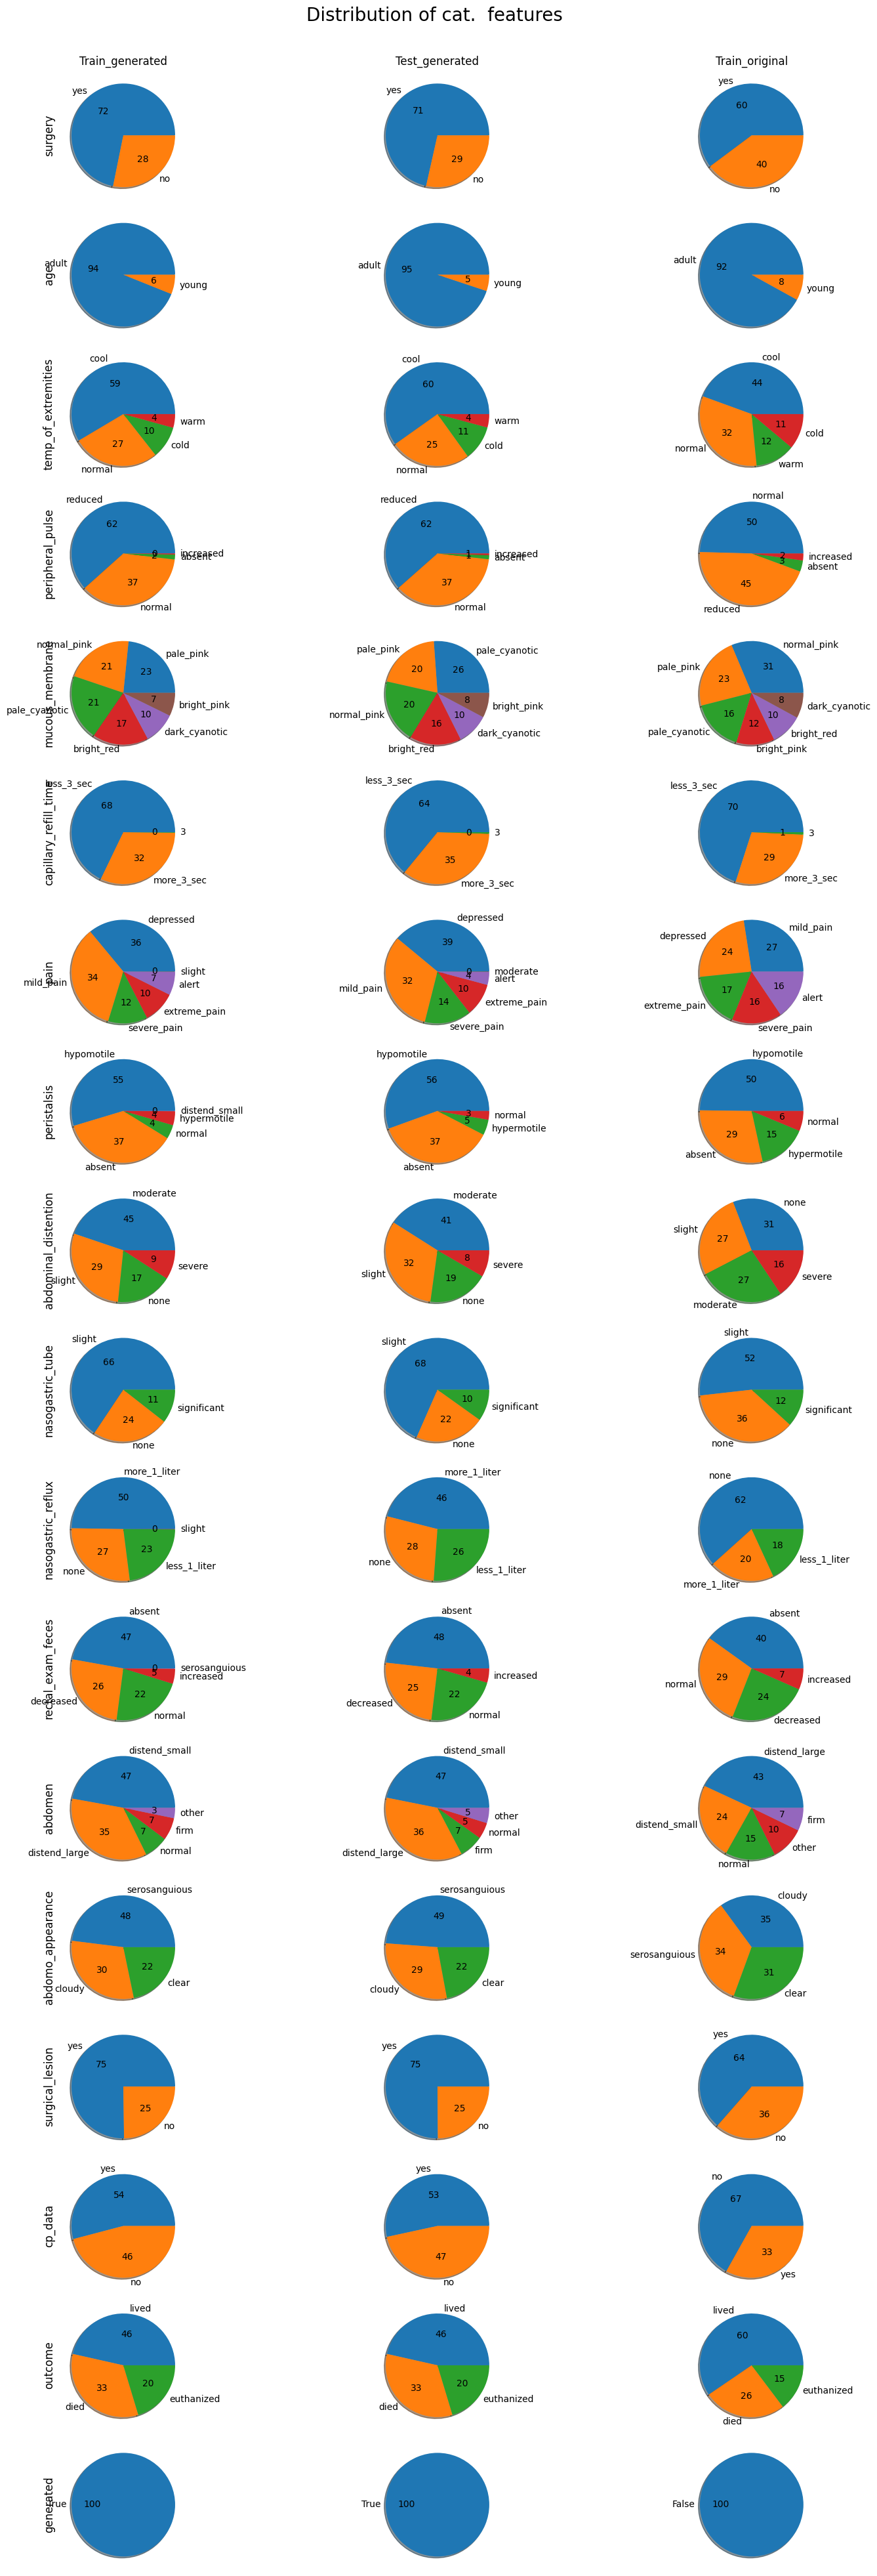

In [26]:
custom_plot4(train_df, test_df, original_df, categorical_features, 'Distribution of cat. ', autopct='%1.f')

In [27]:
def custom_plot5(plot_func, train, orig, columns, name, figsize=(20,70),names = ['Train_generated',  'Train_original'],
                 *args, **kwargs):
    fig, axs = plt.subplots(len(columns), 2, figsize = figsize)
    fig.suptitle(f'{name}' + ' features \n \n', fontsize = 50)
    
    for i, col in enumerate(columns):
        plot_func(data=train, x=col, ax=axs[i][0], order = sorted(train[col].value_counts().index),
                  *args, **kwargs)
        plot_func(data=orig, x=col, ax=axs[i][1], order = sorted(orig[col].value_counts().index),
                  *args, **kwargs)
            
        axs[i][0].legend(fontsize=15)
        axs[i][1].legend(fontsize=15)
        
    for ax, col in zip(axs[0], names):
        ax.set_title(col, fontsize=30)

    for ax, row in zip(axs[:,0], columns):
        ax.set_ylabel(row, rotation=90, fontsize=20)
        
    plt.tight_layout()

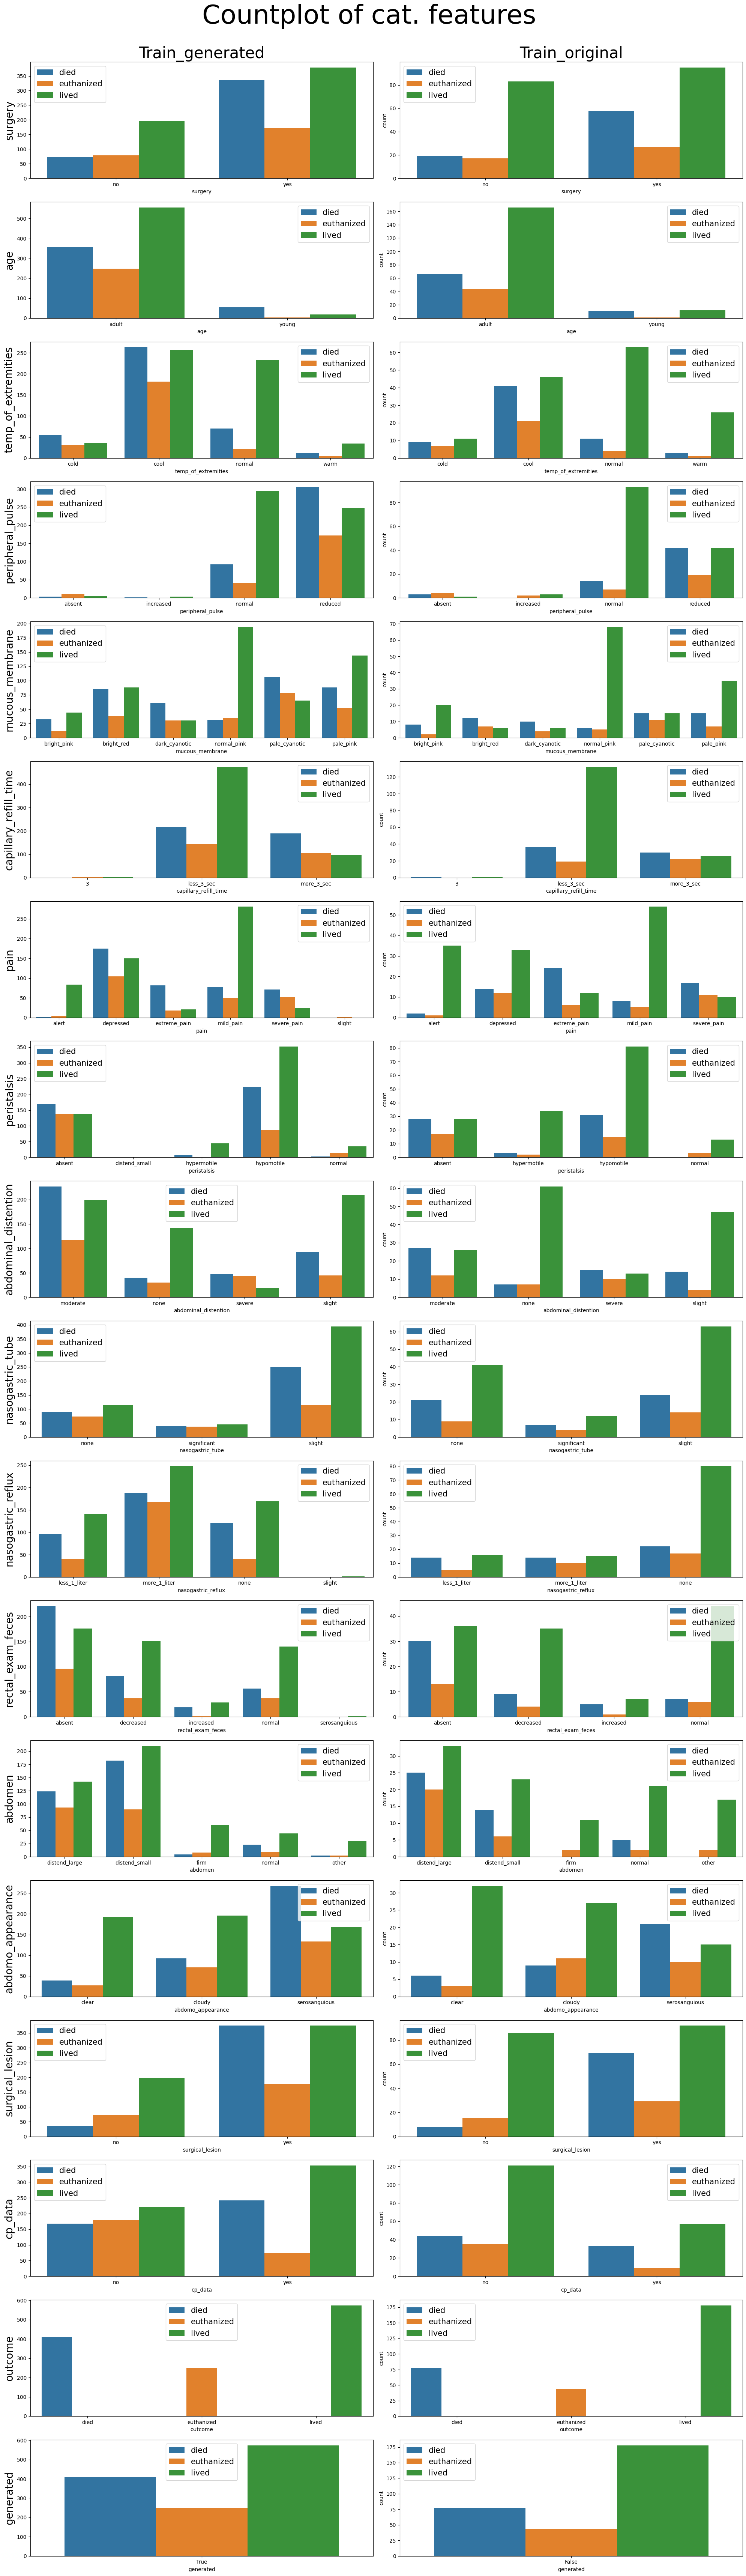

In [28]:
custom_plot5(sns.countplot, train_df, original_df, categorical_features, 'Countplot of cat.', hue='outcome')

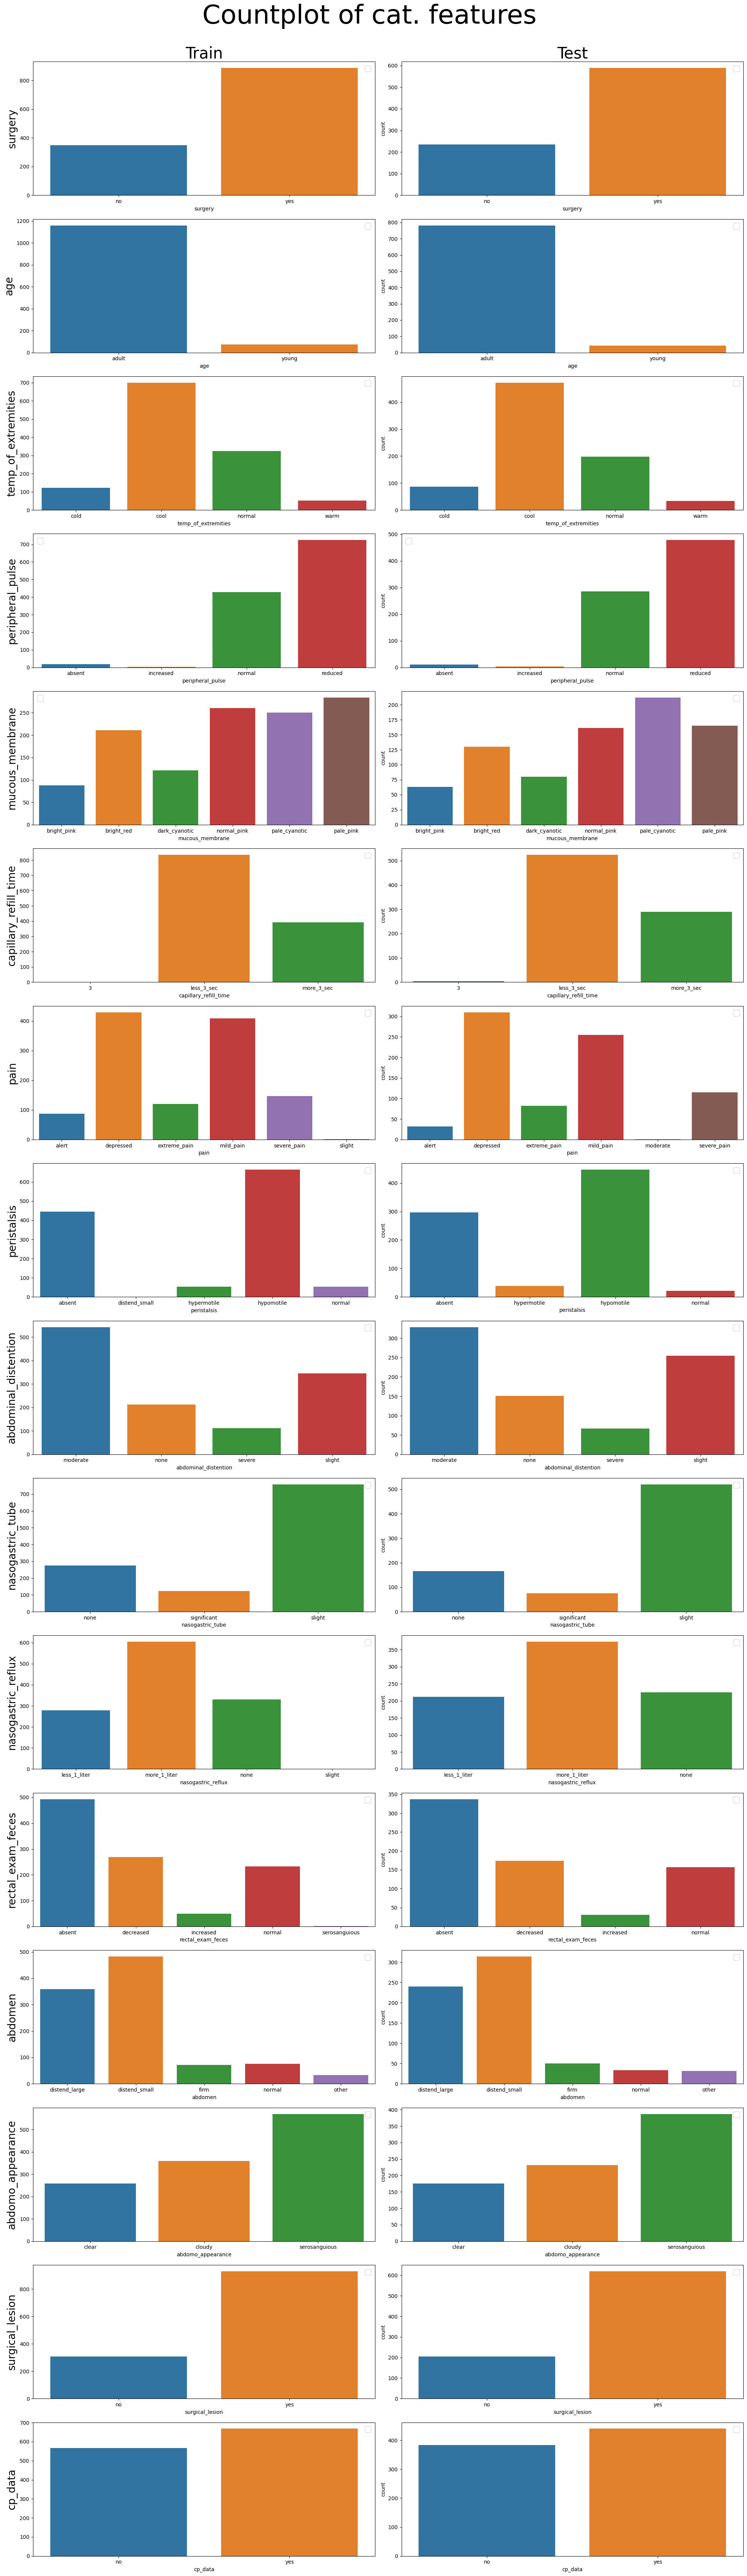

In [29]:
custom_plot5(sns.countplot, train_df, test_df, categorical_features[:-2], 'Countplot of cat.',
             names = ['Train',  'Test'])

Ratio of target's bars in `countplot` are kinda similar in different datasets

## 3. Baseline

By pipeline below, in `baseline` chapter, I got 0.77439 on test

## 3.1. Preprocessing

Let's make a dataset of features' statistics

There is a function `describe` in pandas, which counts statistics for numeric features

In [30]:
new_train_df.describe().T

count           mean           std       min  \
hospital_number        1534.0  980469.409387  1.392849e+06  518476.0   
rectal_temp            1474.0      38.196744  7.798830e-01      35.4   
pulse                  1510.0      78.194702  2.916252e+01      30.0   
respiratory_rate       1476.0      30.120596  1.665080e+01       8.0   
nasogastric_reflux_ph  1288.0       4.395963  1.939516e+00       1.0   
packed_cell_volume     1505.0      49.011296  1.059043e+01      23.0   
total_protein          1501.0      21.899534  2.681306e+01       3.3   
abdomo_protein         1336.0       3.271931  1.621415e+00       0.1   
lesion_1               1534.0    3798.817471  5.429908e+03       0.0   
lesion_2               1534.0      29.409387  3.367483e+02       0.0   
lesion_3               1534.0       4.320078  9.762481e+01       0.0   

                            25%       50%        75%        max  
hospital_number        528806.0  529840.0  534259.25  5305629.0  
rectal_temp                37.8      38.2      38.60       40.8  
pulse                      52.0      72.0      96.00      184.0  
respiratory_rate           18.0      28.0      36.00       96.0  
nasogastric_reflux_ph       2.0       4.5       6.20        7.5  
packed_cell_volume         42.0      48.0      55.00       75.0  
total_protein               6.6       7.5      13.00       89.0  
abdomo_protein              2.0       3.0       4.30       10.1  
lesion_1                 2124.0    2209.0    3205.00    41110.0  
lesion_2                    0.0       0.0       0.00     7111.0  
lesion_3                    0.0       0.0       0.00     2209.0

We'll add more statistics

In [31]:
def construct_features_df(df):
    features_df = pd.DataFrame(index=df.columns)
    features_df['nunique'] = df.nunique() #cnt of unique elements
    features_df['count'] = df.count() #cnt of non nans
    features_df['nan'] = df.isna().sum()
    features_df['precent_nan'] = features_df['nan'] / (features_df['nan'] + features_df['count'])
    features_df['dtype'] = df.dtypes
    
    features_df = pd.concat([features_df, df.describe().T], axis=1, join='outer')
    return features_df

In [32]:
features_train = construct_features_df(new_train_df)
features_test = construct_features_df(test_df)

In [33]:
features_train

nunique  count  nan  precent_nan    dtype   count  \
surgery                      2   1534    0     0.000000   object     NaN   
age                          2   1534    0     0.000000   object     NaN   
hospital_number            288   1534    0     0.000000    int64  1534.0   
rectal_temp                 43   1474   60     0.039113  float64  1474.0   
pulse                       52   1510   24     0.015645  float64  1510.0   
respiratory_rate            40   1476   58     0.037810  float64  1476.0   
temp_of_extremities          4   1439   95     0.061930   object     NaN   
peripheral_pulse             4   1405  129     0.084094   object     NaN   
mucous_membrane              6   1466   68     0.044329   object     NaN   
capillary_refill_time        3   1496   38     0.024772   object     NaN   
pain                         6   1435   99     0.064537   object     NaN   
peristalsis                  5   1470   64     0.041721   object     NaN   
abdominal_distention         4   1455   79     0.051499   object     NaN   
nasogastric_tube             3   1350  184     0.119948   object     NaN   
nasogastric_reflux           4   1407  127     0.082790   object     NaN   
nasogastric_reflux_ph       26   1288  246     0.160365  float64  1288.0   
rectal_exam_feces            5   1242  292     0.190352   object     NaN   
abdomen                      5   1203  331     0.215776   object     NaN   
packed_cell_volume          50   1505   29     0.018905  float64  1505.0   
total_protein               86   1501   33     0.021512  float64  1501.0   
abdomo_appearance            3   1321  213     0.138853   object     NaN   
abdomo_protein              54   1336  198     0.129074  float64  1336.0   
surgical_lesion              2   1534    0     0.000000   object     NaN   
lesion_1                    62   1534    0     0.000000    int64  1534.0   
lesion_2                     6   1534    0     0.000000    int64  1534.0   
lesion_3                     2   1534    0     0.000000    int64  1534.0   
cp_data                      2   1534    0     0.000000   object     NaN   
outcome                      3   1534    0     0.000000   object     NaN   
generated                    2   1534    0     0.000000   object     NaN   

                                mean           std       min       25%  \
surgery                          NaN           NaN       NaN       NaN   
age                              NaN           NaN       NaN       NaN   
hospital_number        980469.409387  1.392849e+06  518476.0  528806.0   
rectal_temp                38.196744  7.798830e-01      35.4      37.8   
pulse                      78.194702  2.916252e+01      30.0      52.0   
respiratory_rate           30.120596  1.665080e+01       8.0      18.0   
temp_of_extremities              NaN           NaN       NaN       NaN   
peripheral_pulse                 NaN           NaN       NaN       NaN   
mucous_membrane                  NaN           NaN       NaN       NaN   
capillary_refill_time            NaN           NaN       NaN       NaN   
pain                             NaN           NaN       NaN       NaN   
peristalsis                      NaN           NaN       NaN       NaN   
abdominal_distention             NaN           NaN       NaN       NaN   
nasogastric_tube                 NaN           NaN       NaN       NaN   
nasogastric_reflux               NaN           NaN       NaN       NaN   
nasogastric_reflux_ph       4.395963  1.939516e+00       1.0       2.0   
rectal_exam_feces                NaN           NaN       NaN       NaN   
abdomen                          NaN           NaN       NaN       NaN   
packed_cell_volume         49.011296  1.059043e+01      23.0      42.0   
total_protein              21.899534  2.681306e+01       3.3       6.6   
abdomo_appearance                NaN           NaN       NaN       NaN   
abdomo_protein              3.271931  1.621415e+00       0.1       2.0   
surgical_lesion                  NaN    

In [34]:
features_test

nunique  count  nan  precent_nan    dtype  count  \
surgery                      2    824    0     0.000000   object    NaN   
age                          2    824    0     0.000000   object    NaN   
hospital_number            210    824    0     0.000000    int64  824.0   
rectal_temp                 34    824    0     0.000000  float64  824.0   
pulse                       49    824    0     0.000000  float64  824.0   
respiratory_rate            38    824    0     0.000000  float64  824.0   
temp_of_extremities          4    789   35     0.042476   object    NaN   
peripheral_pulse             4    777   47     0.057039   object    NaN   
mucous_membrane              6    811   13     0.015777   object    NaN   
capillary_refill_time        3    818    6     0.007282   object    NaN   
pain                         6    795   29     0.035194   object    NaN   
peristalsis                  4    805   19     0.023058   object    NaN   
abdominal_distention         4    802   22     0.026699   object    NaN   
nasogastric_tube             3    760   64     0.077670   object    NaN   
nasogastric_reflux           3    810   14     0.016990   object    NaN   
nasogastric_reflux_ph       29    824    0     0.000000  float64  824.0   
rectal_exam_feces            4    699  125     0.151699   object    NaN   
abdomen                      5    670  154     0.186893   object    NaN   
packed_cell_volume          48    824    0     0.000000  float64  824.0   
total_protein               72    824    0     0.000000  float64  824.0   
abdomo_appearance            3    793   31     0.037621   object    NaN   
abdomo_protein              50    824    0     0.000000  float64  824.0   
surgical_lesion              2    824    0     0.000000   object    NaN   
lesion_1                    54    824    0     0.000000    int64  824.0   
lesion_2                     4    824    0     0.000000    int64  824.0   
lesion_3                     1    824    0     0.000000    int64  824.0   
cp_data                      2    824    0     0.000000   object    NaN   
generated                    1    824    0     0.000000   object    NaN   

                               mean           std       min       25%  \
surgery                         NaN           NaN       NaN       NaN   
age                             NaN           NaN       NaN       NaN   
hospital_number        1.108357e+06  1.555627e+06  521399.0  528743.0   
rectal_temp            3.824454e+01  7.852339e-01      36.0      37.8   
pulse                  8.022937e+01  2.916471e+01      36.0      54.0   
respiratory_rate       3.071966e+01  1.743191e+01       9.0      18.0   
temp_of_extremities             NaN           NaN       NaN       NaN   
peripheral_pulse                NaN           NaN       NaN       NaN   
mucous_membrane                 NaN           NaN       NaN       NaN   
capillary_refill_time           NaN           NaN       NaN       NaN   
pain                            NaN           NaN       NaN       NaN   
peristalsis                     NaN           NaN       NaN       NaN   
abdominal_distention            NaN           NaN       NaN       NaN   
nasogastric_tube                NaN           NaN       NaN       NaN   
nasogastric_reflux              NaN           NaN       NaN       NaN   
nasogastric_reflux_ph  4.508495e+00  1.883464e+00       1.0       3.0   
rectal_exam_feces               NaN           NaN       NaN       NaN   
abdomen                         NaN           NaN       NaN       NaN   
packed_cell_volume     4.906335e+01  1.045014e+01      23.0      43.0   
total_protein          2.079624e+01  2.641359e+01       3.9       6.6   
abdomo_appearance               NaN           NaN       NaN       NaN   
abdomo_protein         3.336420e+00  1.539235e+00       0.1       2.0   
surgical_lesion                 NaN           NaN       NaN       NaN   
lesion_1               3.709803e+03  5.112931e+03       0.0    2205.0   
lesion_2              

1. There are a lot of categorical features. If for some feature `nunique` (number of unique values) is different in train and test, this feature is either numeric (and it is okay), or it is categorical and we need to fix this.
2. Data has missing values. We can fill them with mean / median value or learn some knn model to predict missing value.

In [35]:
cat_features_with_different_set_of_values = []
for col in categorical_features[:-2]: # with no 'outcome' and 'generated'
    if len(set(new_train_df[col].value_counts().keys()) ^ set(test_df[col].value_counts().keys())) != 0:
        cat_features_with_different_set_of_values.append(col)

In [36]:
for col in cat_features_with_different_set_of_values:
    print(f'Conflict values for feature \"{col}\":')
    conflict_values = set(new_train_df[col].value_counts().keys()) ^ set(test_df[col].value_counts().keys())
    
    print('\t', end='')
    for val in conflict_values:
        print(val, end=' ')
        
    print('\n')

Conflict values for feature "pain":
	slight moderate 

Conflict values for feature "peristalsis":
	distend_small 

Conflict values for feature "nasogastric_reflux":
	slight 

Conflict values for feature "rectal_exam_feces":
	serosanguious 



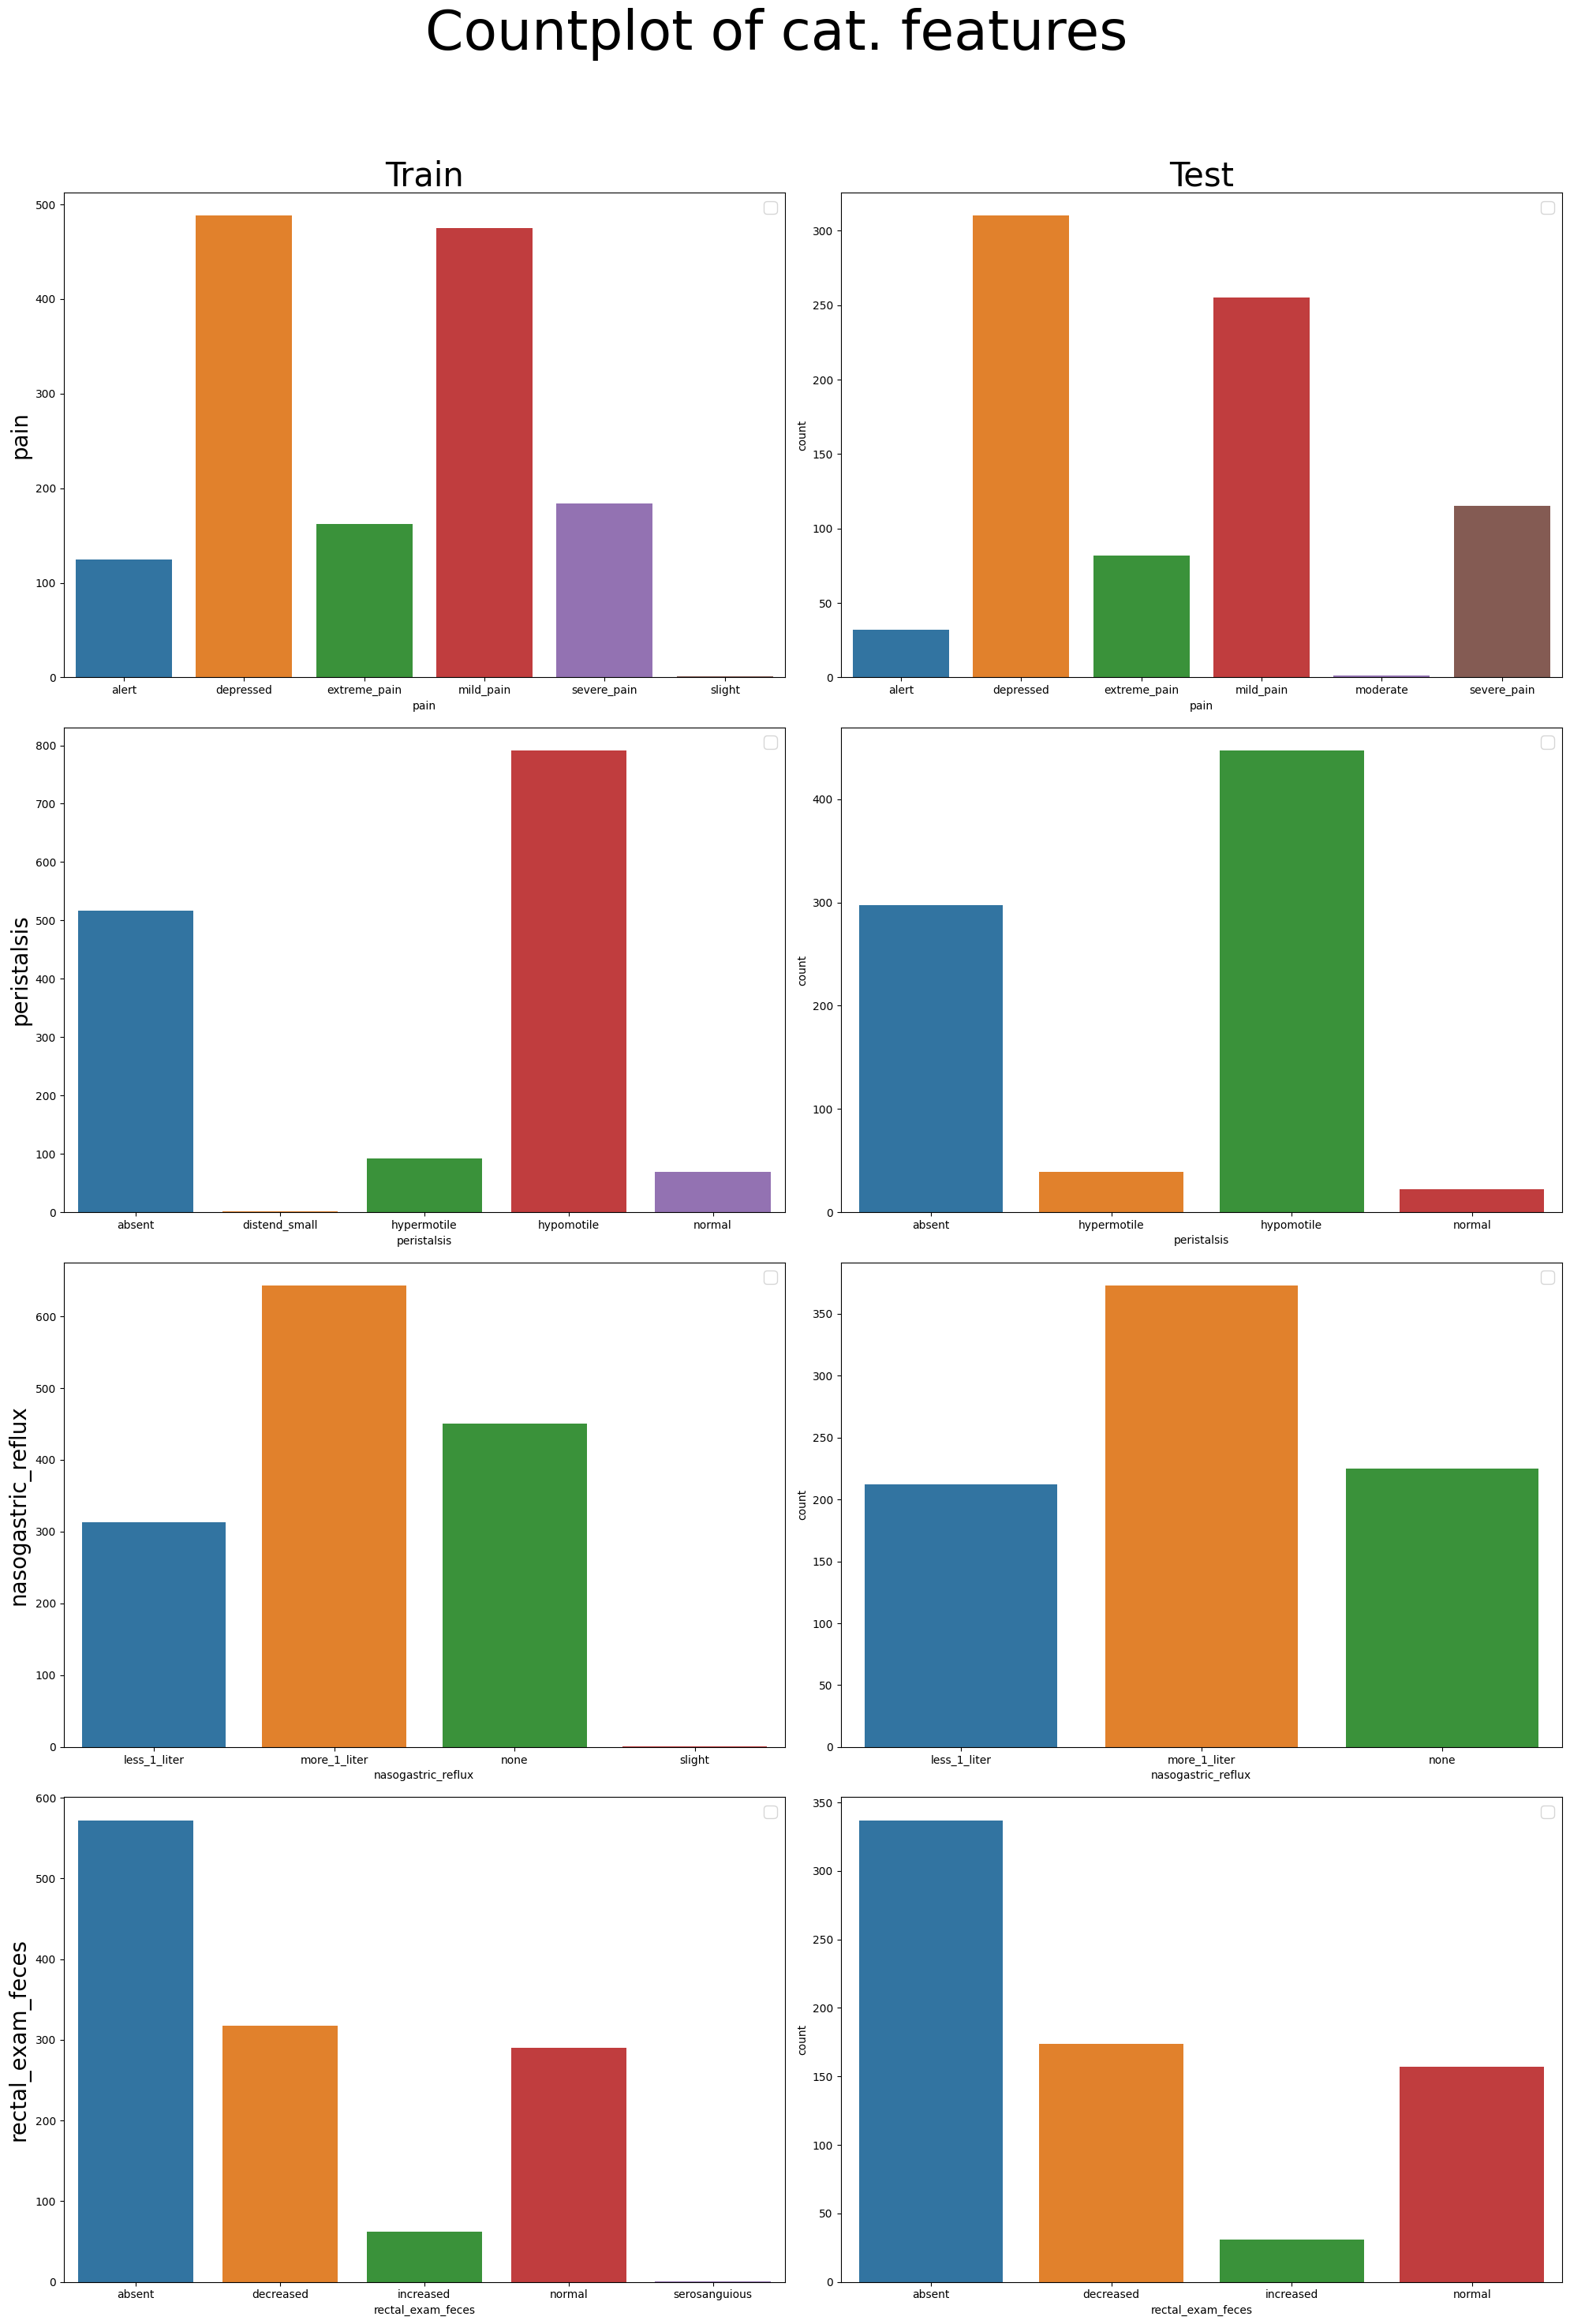

In [37]:
custom_plot5(sns.countplot, new_train_df, test_df, cat_features_with_different_set_of_values,
             'Countplot of cat.', figsize=(20,30), names = ['Train', 'Test'])

Fixing the conflicts:

In [38]:
new_train_df['pain']=new_train_df['pain'].replace('slight','mild_pain')
test_df['pain']=test_df['pain'].replace('moderate','mild_pain')

new_train_df['peristalsis']=new_train_df['peristalsis'].replace('distend_small','hypermotile')
new_train_df['nasogastric_reflux']=new_train_df['nasogastric_reflux'].replace('slight','less_1_liter')
new_train_df['rectal_exam_feces']=new_train_df['rectal_exam_feces'].replace('serosanguious','increased')

In [39]:
cat_features_with_different_set_of_values = []
for col in categorical_features[:-2]: # with no 'outcome' and 'generated'
    if len(set(new_train_df[col].value_counts().keys()) ^ set(test_df[col].value_counts().keys())) != 0:
        cat_features_with_different_set_of_values.append(col)
cat_features_with_different_set_of_values

[]

Now train and test have equal set of categorial features.

We need to replace NaNs. For numerical features we'll take median, and for categorial data we'll take mode

In [40]:
for col in numeric_features:
    new_train_df[col] = new_train_df[col].fillna(new_train_df[col].median())
    test_df[col] = test_df[col].fillna(test_df[col].median())

In [41]:
for col in categorical_features[:-2]: # no outcome and generated
    new_train_df[col] = new_train_df[col].fillna(new_train_df[col].mode()[0])
    test_df[col] = test_df[col].fillna(test_df[col].mode()[0])

Let's have a final look to feature's statistics

In [42]:
features_train = construct_features_df(new_train_df)
features_test = construct_features_df(test_df)

In [43]:
features_train

nunique  count  nan  precent_nan    dtype   count  \
surgery                      2   1534    0          0.0   object     NaN   
age                          2   1534    0          0.0   object     NaN   
hospital_number            288   1534    0          0.0    int64  1534.0   
rectal_temp                 43   1534    0          0.0  float64  1534.0   
pulse                       52   1534    0          0.0  float64  1534.0   
respiratory_rate            40   1534    0          0.0  float64  1534.0   
temp_of_extremities          4   1534    0          0.0   object     NaN   
peripheral_pulse             4   1534    0          0.0   object     NaN   
mucous_membrane              6   1534    0          0.0   object     NaN   
capillary_refill_time        3   1534    0          0.0   object     NaN   
pain                         5   1534    0          0.0   object     NaN   
peristalsis                  4   1534    0          0.0   object     NaN   
abdominal_distention         4   1534    0          0.0   object     NaN   
nasogastric_tube             3   1534    0          0.0   object     NaN   
nasogastric_reflux           3   1534    0          0.0   object     NaN   
nasogastric_reflux_ph       26   1534    0          0.0  float64  1534.0   
rectal_exam_feces            4   1534    0          0.0   object     NaN   
abdomen                      5   1534    0          0.0   object     NaN   
packed_cell_volume          50   1534    0          0.0  float64  1534.0   
total_protein               86   1534    0          0.0  float64  1534.0   
abdomo_appearance            3   1534    0          0.0   object     NaN   
abdomo_protein              54   1534    0          0.0  float64  1534.0   
surgical_lesion              2   1534    0          0.0   object     NaN   
lesion_1                    62   1534    0          0.0    int64  1534.0   
lesion_2                     6   1534    0          0.0    int64  1534.0   
lesion_3                     2   1534    0          0.0    int64  1534.0   
cp_data                      2   1534    0          0.0   object     NaN   
outcome                      3   1534    0          0.0   object     NaN   
generated                    2   1534    0          0.0   object     NaN   

                                mean           std       min       25%  \
surgery                          NaN           NaN       NaN       NaN   
age                              NaN           NaN       NaN       NaN   
hospital_number        980469.409387  1.392849e+06  518476.0  528806.0   
rectal_temp                38.196871  7.644690e-01      35.4      37.8   
pulse                      78.097784  2.894356e+01      30.0      52.0   
respiratory_rate           30.040417  1.633779e+01       8.0      18.0   
temp_of_extremities              NaN           NaN       NaN       NaN   
peripheral_pulse                 NaN           NaN       NaN       NaN   
mucous_membrane                  NaN           NaN       NaN       NaN   
capillary_refill_time            NaN           NaN       NaN       NaN   
pain                             NaN           NaN       NaN       NaN   
peristalsis                      NaN           NaN       NaN       NaN   
abdominal_distention             NaN           NaN       NaN       NaN   
nasogastric_tube                 NaN           NaN       NaN       NaN   
nasogastric_reflux               NaN           NaN       NaN       NaN   
nasogastric_reflux_ph       4.412647  1.777509e+00       1.0       3.0   
rectal_exam_feces                NaN           NaN       NaN       NaN   
abdomen                          NaN           NaN       NaN       NaN   
packed_cell_volume         48.992177  1.049068e+01      23.0      42.0   
total_protein              21.589765  2.660510e+01       3.3       6.6   
abdomo_appearance                NaN           NaN       NaN       NaN   
abdomo_protein              3.236832  1.515833e+00       0.1       2.0   
surgical_lesion                  NaN    

In [44]:
features_test

nunique  count  nan  precent_nan    dtype  count  \
surgery                      2    824    0          0.0   object    NaN   
age                          2    824    0          0.0   object    NaN   
hospital_number            210    824    0          0.0    int64  824.0   
rectal_temp                 34    824    0          0.0  float64  824.0   
pulse                       49    824    0          0.0  float64  824.0   
respiratory_rate            38    824    0          0.0  float64  824.0   
temp_of_extremities          4    824    0          0.0   object    NaN   
peripheral_pulse             4    824    0          0.0   object    NaN   
mucous_membrane              6    824    0          0.0   object    NaN   
capillary_refill_time        3    824    0          0.0   object    NaN   
pain                         5    824    0          0.0   object    NaN   
peristalsis                  4    824    0          0.0   object    NaN   
abdominal_distention         4    824    0          0.0   object    NaN   
nasogastric_tube             3    824    0          0.0   object    NaN   
nasogastric_reflux           3    824    0          0.0   object    NaN   
nasogastric_reflux_ph       29    824    0          0.0  float64  824.0   
rectal_exam_feces            4    824    0          0.0   object    NaN   
abdomen                      5    824    0          0.0   object    NaN   
packed_cell_volume          48    824    0          0.0  float64  824.0   
total_protein               72    824    0          0.0  float64  824.0   
abdomo_appearance            3    824    0          0.0   object    NaN   
abdomo_protein              50    824    0          0.0  float64  824.0   
surgical_lesion              2    824    0          0.0   object    NaN   
lesion_1                    54    824    0          0.0    int64  824.0   
lesion_2                     4    824    0          0.0    int64  824.0   
lesion_3                     1    824    0          0.0    int64  824.0   
cp_data                      2    824    0          0.0   object    NaN   
generated                    1    824    0          0.0   object    NaN   

                               mean           std       min       25%  \
surgery                         NaN           NaN       NaN       NaN   
age                             NaN           NaN       NaN       NaN   
hospital_number        1.108357e+06  1.555627e+06  521399.0  528743.0   
rectal_temp            3.824454e+01  7.852339e-01      36.0      37.8   
pulse                  8.022937e+01  2.916471e+01      36.0      54.0   
respiratory_rate       3.071966e+01  1.743191e+01       9.0      18.0   
temp_of_extremities             NaN           NaN       NaN       NaN   
peripheral_pulse                NaN           NaN       NaN       NaN   
mucous_membrane                 NaN           NaN       NaN       NaN   
capillary_refill_time           NaN           NaN       NaN       NaN   
pain                            NaN           NaN       NaN       NaN   
peristalsis                     NaN           NaN       NaN       NaN   
abdominal_distention            NaN           NaN       NaN       NaN   
nasogastric_tube                NaN           NaN       NaN       NaN   
nasogastric_reflux              NaN           NaN       NaN       NaN   
nasogastric_reflux_ph  4.508495e+00  1.883464e+00       1.0       3.0   
rectal_exam_feces               NaN           NaN       NaN       NaN   
abdomen                         NaN           NaN       NaN       NaN   
packed_cell_volume     4.906335e+01  1.045014e+01      23.0      43.0   
total_protein          2.079624e+01  2.641359e+01       3.9       6.6   
abdomo_appearance               NaN           NaN       NaN       NaN   
abdomo_protein         3.336420e+00  1.539235e+00       0.1       2.0   
surgical_lesion                 NaN           NaN       NaN       NaN   
lesion_1               3.709803e+03  5.112931e+03       0.0    2205.0   
lesion_2              

Well done. 

Now we need to deal with categorical features. 

If we use logistic regression / neural network we need to use label encoding or one hot. But as for boosting, boosting models can deal with cat. features, so at this moment we dont encode them


## 3.2. Adversarial validation

Good notebook https://www.kaggle.com/code/carlmcbrideellis/what-is-adversarial-validation

Previously we established that train and test has the same distribution based on graphs. But we can establish this in more proper way: adversarial validation.

Basically, we train our model to classify if object is from train ds or test. If area under ROC-curve is ~ 0.5 then distributions are same.

We'll do adversarial validation not only to establish same distribution for real and generated data, but also to stablish same distribution for train and test

We'll use XGB boost for adversarial validation

In [45]:
adv_train_gen = train_df.copy()
adv_test_gen = test_df.copy()
adv_train_orig = original_df.copy()
adv_all_train = new_train_df.copy()

In [46]:
adv_train_orig.columns

Index(['surgery', 'age', 'hospital_number', 'rectal_temp', 'pulse',
       'respiratory_rate', 'temp_of_extremities', 'peripheral_pulse',
       'mucous_membrane', 'capillary_refill_time', 'pain', 'peristalsis',
       'abdominal_distention', 'nasogastric_tube', 'nasogastric_reflux',
       'nasogastric_reflux_ph', 'rectal_exam_feces', 'abdomen',
       'packed_cell_volume', 'total_protein', 'abdomo_appearance',
       'abdomo_protein', 'surgical_lesion', 'lesion_1', 'lesion_2', 'lesion_3',
       'cp_data', 'outcome', 'generated'],
      dtype='object')

In [47]:
adv_test_gen = test_df.copy()
adv_all_train = new_train_df.copy()

for df in [adv_test_gen, adv_all_train]:
    df.drop(['generated'], axis=1, errors='ignore', inplace=True)
    
categorical_features2 = deepcopy(categorical_features)
categorical_features2.insert(2, 'hospital_number')
categorical_features2.remove('outcome')
categorical_features2.remove('generated')

In [48]:
for df in [adv_train_gen, adv_test_gen, adv_train_orig, adv_all_train]:
    df.drop(['outcome', 'generated'], axis=1, errors='ignore', inplace=True)

In [49]:
def adversarial_validation(df1, df2, cat_feat, y):
    df3 = pd.concat([df1,df2])
    for col in cat_feat:
        df3[col] = df3[col].astype('category')
    
#     XGBdata = xgb.DMatrix(data=df3.drop([y], axis=1), label=df3[y], enable_categorical=True)
    
    # our XGBoost parameters
    params = {"objective":"binary:logistic",
              "eval_metric":"logloss",
              'learning_rate': 0.05,
             'enable_categorical': True,
              'tree_method':"hist"}
    
    param_grid = { 
    # Percentage of columns to be randomly samples for each tree.
    "colsample_bytree": [ 0.3, 0.5 , 0.8 ], 
    "reg_alpha": [0, 0.5, 1, 5], #l1 reg
    "reg_lambda": [0, 0.5, 1, 5],#l2 reg
        
    'n_estimators': [50, 100],
    "max_depth" : [10, 20, 40]        
    }
    
    
    grid_search = GridSearchCV(XGBClassifier(**params), 
                           param_grid=param_grid, 
                           scoring='roc_auc',
                           n_jobs=-1, 
                               cv=5,  # stratified kfold as default
                              )
    grid_result = grid_search.fit(X=df3.drop([y], axis=1), y=df3[y])
    return grid_result
                               
   

        # Other method for cross validation, implemented in xgb
#     cross_val_results = cv(dtrain=XGBdata, params=params, 
#                            nfold=5, metrics="auc", 
#                            num_boost_round=200,early_stopping_rounds=20,
#                            as_pandas=True)
    
    
#     return cross_val_results.sort_values(by='test-auc-mean', ascending=False).head(1)['test-auc-mean']
    
    

In [50]:
adv_all_train['is_train'] = 1
adv_test_gen['is_train'] = 0
res = adversarial_validation(adv_all_train, adv_test_gen, categorical_features2, 'is_train')

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [51]:
pd.DataFrame(res.cv_results_).sort_values(by='rank_test_score').head(5)

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
189       0.378353      0.005240         0.022537        0.000871   
157       0.383466      0.004040         0.024065        0.001196   
159       0.375320      0.004551         0.025509        0.003387   
191       0.366870      0.001779         0.022708        0.000826   
31        0.269225      0.003467         0.022759        0.000639   

    param_colsample_bytree param_max_depth param_n_estimators param_reg_alpha  \
189                    0.5              40                100               5   
157                    0.5              20                100               5   
159                    0.5              20                100               5   
191                    0.5              40                100               5   
31                     0.3              10                100               5   

    param_reg_lambda                                             params  \
189              0.5  {'colsample_bytree': 0.5, 'max_depth': 40, 'n_...   
157              0.5  {'colsample_bytree': 0.5, 'max_depth': 20, 'n_...   
159                5  {'colsample_bytree': 0.5, 'max_depth': 20, 'n_...   
191                5  {'colsample_bytree': 0.5, 'max_depth': 40, 'n_...   
31                 5  {'colsample_bytree': 0.3, 'max_depth': 10, 'n_...   

     split0_test_score  split1_test_score  split2_test_score  \
189           0.604462           0.633718           0.594532   
157           0.604462           0.633718           0.594532   
159           0.606692           0.629770           0.594354   
191           0.606692           0.629770           0.594354   
31            0.604718           0.624933           0.590722   

     split3_test_score  split4_test_score  mean_test_score  std_test_score  \
189           0.603460           0.601079         0.607450        0.013582   
157           0.603460           0.601079         0.607450        0.013582   
159           0.608882           0.589869         0.605914        0.013925   
191           0.608882           0.589869         0.605914        0.013925   
31            0.611027           0.597217         0.605724        0.011795   

     rank_test_score  
189                1  
157                1  
159                3  
191                3  
31                 5

In [52]:
pd.DataFrame(res.cv_results_).sort_values(by='rank_test_score').iloc[0]['mean_test_score']

0.6074501640497368

Area under roc-curve is 0.6

![](https://media.tenor.com/wtg92v8U6fMAAAAC/chernobyl-not-great.gif) 

I think we are okay with that. We can plot most important features and try removing them one by one and train classifier again, until we get ~0.5

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

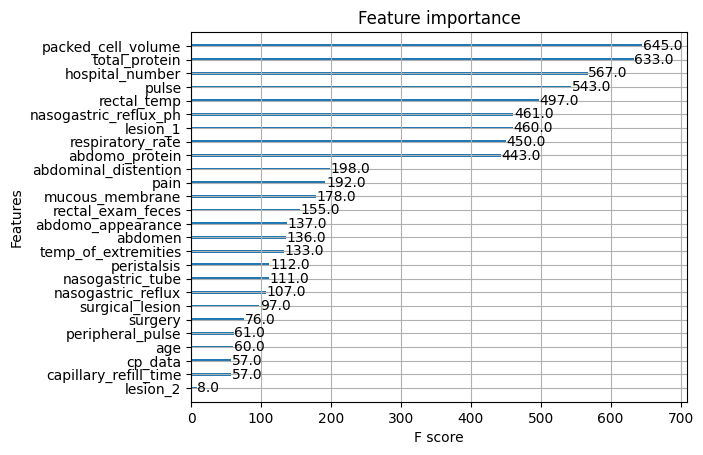

In [53]:
plot_importance(res.best_estimator_)

But i'm not doing that :)

## 3.3 CatBoost

It is a known fact that boosting is the best tecnique for working with table data. We'll try [CatBoost](https://catboost.ai/)

In [54]:
test_gen = test_df.copy()
train_all = new_train_df.copy()

for df in [test_gen, train_all]:
    df.drop(['generated'], axis=1, errors='ignore', inplace=True)
    
categorical_features2 = deepcopy(categorical_features)
categorical_features2.insert(2, 'hospital_number')
categorical_features2.remove('outcome')
categorical_features2.remove('generated')

We can use `cb.grid_search`

In [55]:
# clf = cb.CatBoostClassifier(loss_function='MultiClass', eval_metric = 'TotalF1:average=Macro',verbose=0)

# train_pool = cb.Pool(train_all.drop('outcome', axis=1), 
#                   label=train_all['outcome'],
#                   cat_features=categorical_features2)

# grid_search_result = clf.grid_search(grid, cv=5,
#                                        X=train_pool, verbose=False, refit=True,
#                                        plot=False)

But we will use Sklearn's grid_search

https://github.com/catboost/catboost/issues/172#issuecomment-965902765

In [56]:
cat_feat_idx = []
for i ,col in enumerate(train_all.drop('outcome', axis=1).columns):
    if col in categorical_features2:
        cat_feat_idx.append(i)
cat_feat_idx        

[0, 1, 2, 6, 7, 8, 9, 10, 11, 12, 13, 14, 16, 17, 20, 22, 26]

In [57]:
np.all(np.array(categorical_features2) == np.array(train_all.drop('outcome', axis=1).columns)[cat_feat_idx])

True

In [58]:
clf = cb.CatBoostClassifier(loss_function='MultiClass', 
                            eval_metric = 'TotalF1:average=Macro',
                            verbose=0,
                            cat_features=cat_feat_idx,
                            learning_rate = 0.05)

grid = {'max_depth': [5, 7], 'l2_leaf_reg': [0.01, 0.1], 'n_estimators':[300, 400]
#                                 random_strength = 0.5,
#                                 bagging_temperature = 0.7,
#                                 border_count = 30,
#                                 l2_leaf_reg = 5,
         }

clf_grid = GridSearchCV(estimator=clf, param_grid=grid, scoring='f1_micro', cv=5, verbose=1)

In [59]:
clf_grid.fit(X=train_all.drop('outcome', axis=1), y = train_all['outcome'])

Fitting 5 folds for each of 8 candidates, totalling 40 fits


GridSearchCV(cv=5,
             estimator=<catboost.core.CatBoostClassifier object at 0x7f54bc622140>,
             param_grid={'l2_leaf_reg': [0.01, 0.1], 'max_depth': [5, 7],
                         'n_estimators': [300, 400]},
             scoring='f1_micro', verbose=1)

In [60]:
pd.DataFrame(clf_grid.cv_results_).sort_values(by=['mean_test_score'], ascending=False).head(5)

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
5       6.371216      0.340848         0.007965        0.000154   
7      31.832625      0.232572         0.009028        0.000155   
1       6.289644      0.311808         0.008170        0.000215   
3      31.459975      0.188355         0.009475        0.000741   
2      24.577344      1.395886         0.009775        0.003051   

  param_l2_leaf_reg param_max_depth param_n_estimators  \
5               0.1               5                400   
7               0.1               7                400   
1              0.01               5                400   
3              0.01               7                400   
2              0.01               7                300   

                                              params  split0_test_score  \
5  {'l2_leaf_reg': 0.1, 'max_depth': 5, 'n_estima...           0.736156   
7  {'l2_leaf_reg': 0.1, 'max_depth': 7, 'n_estima...           0.736156   
1  {'l2_leaf_reg': 0.01, 'max_depth': 5, 'n_estim...           0.719870   
3  {'l2_leaf_reg': 0.01, 'max_depth': 7, 'n_estim...           0.723127   
2  {'l2_leaf_reg': 0.01, 'max_depth': 7, 'n_estim...           0.723127   

   split1_test_score  split2_test_score  split3_test_score  split4_test_score  \
5           0.736156           0.723127           0.716612           0.705882   
7           0.729642           0.713355           0.723127           0.712418   
1           0.749186           0.697068           0.726384           0.718954   
3           0.729642           0.700326           0.716612           0.732026   
2           0.736156           0.690554           0.713355           0.735294   

   mean_test_score  std_test_score  rank_test_score  
5         0.723587        0.011647                1  
7         0.722940        0.009189                2  
1         0.722292        0.016693                3  
3         0.720347        0.011361                4  
2         0.719697        0.016826                5

In [61]:
clf_grid.best_params_

{'l2_leaf_reg': 0.1, 'max_depth': 5, 'n_estimators': 400}

In [62]:
answers = clf_grid.best_estimator_.predict(test_gen)

In [63]:
sample_df['outcome'] = answers.flatten()
sample_df['outcome'].head()

0         lived
1          died
2         lived
3    euthanized
4         lived
Name: outcome, dtype: object

In [64]:
sample_df.to_csv('submission.csv', index=False)

{'l2_leaf_reg': 0.1, 'max_depth': 5, 'n_estimators': 300} - 0.774

## 3.4. Torch Neural Network

As we saw above, our categorical features have a few amount of unique values. Most of them have like 4 unique values. So we'll do one-hot-encoding for them.

But as for `hospital_number`, it has 288 different values. One-hot-encoding will make out dataset too big. Label encoding - categorical feature will have numerical meaning, its not good.

What if try to learn nn.Embeddings?

In [65]:
train = new_train_df.copy()
test = test_df.copy()

In [66]:
for df in [train, test]:
    df.drop(['generated'], axis=1, errors='ignore', inplace=True)
    
categorical_features_to_one_hot = deepcopy(categorical_features)
categorical_features_to_one_hot.remove('outcome')
categorical_features_to_one_hot.remove('generated')

In [67]:
for i in set(test['hospital_number']):
    if i not in set(train['hospital_number']) & set(test['hospital_number']):
        print(i)

528338


Ops, train does not contain all values of `hospital_number` 

In [68]:
test.loc[test['hospital_number'] == 528338 ,'hospital_number'] = train['hospital_number'].mode()[0]

In [69]:
for i in set(test['hospital_number']):
    if i not in set(train['hospital_number']) & set(test['hospital_number']):
        print(i)

In [70]:
onehot = OneHotEncoder()
onehot.fit(train[categorical_features_to_one_hot])
onehot_encoded = onehot.transform(train[categorical_features_to_one_hot])

In [71]:
onehot_encoded_df_train = pd.DataFrame(onehot_encoded.toarray(), columns=
                                 onehot.get_feature_names_out(onehot.feature_names_in_))

numeric_df_train = train.iloc[:, ~train.columns.isin(categorical_features_to_one_hot)]

onehot_encoded_df_train.index = numeric_df_train.index

In [72]:
res_train = pd.concat([onehot_encoded_df_train, numeric_df_train], axis=1)

In [73]:
# Making hospital_num first
cols = np.array(res_train.columns)
cols[0], cols[res_train.columns.get_loc('hospital_number')] = cols[res_train.columns.get_loc('hospital_number')], cols[0]

In [74]:
res_train = res_train[cols]

In [75]:
np.where(res_train.dtypes != np.float64)

(array([ 0, 64, 65, 66, 67]),)

In [76]:
res_train.iloc[:, np.where(res_train.dtypes != np.float64)[0]]

hospital_number  lesion_1  lesion_2  lesion_3     outcome
192            528179      2206         0         0       lived
892           5290409      2205         0         0        died
255            533871      7209         0         0  euthanized
181           5287179      2206         0         0       lived
253            535031      2322         0         0       lived
...               ...       ...       ...       ...         ...
221            528800      2205         0         0       lived
302            529493      2208         0         0  euthanized
172            529729      2207         0         0        died
3             5290409      2208         0         0        died
1211           527883      6111         0         0        died

[1534 rows x 5 columns]

In [77]:
res_train['lesion_1'] = res_train['lesion_1'].astype('float')
res_train['lesion_2'] = res_train['lesion_2'].astype('float')
res_train['lesion_3'] = res_train['lesion_3'].astype('float')

np.where(res_train.dtypes != np.float64)
res_train.iloc[:, np.where(res_train.dtypes != np.float64)[0]]

hospital_number     outcome
192            528179       lived
892           5290409        died
255            533871  euthanized
181           5287179       lived
253            535031       lived
...               ...         ...
221            528800       lived
302            529493  euthanized
172            529729        died
3             5290409        died
1211           527883        died

[1534 rows x 2 columns]

In [78]:
label_enc1 = LabelEncoder()
label_enc2 = LabelEncoder()

label_enc1.fit(res_train['hospital_number'])
res_train['hospital_number'] = label_enc1.transform(res_train['hospital_number'])


In [79]:
label_enc2.fit(res_train['outcome'])
res_train['outcome'] = label_enc2.transform(res_train['outcome'])

In [80]:
res_train

hospital_number  surgery_yes  age_adult  age_young  \
192                38          0.0        1.0        0.0   
892               269          1.0        0.0        1.0   
255               174          1.0        1.0        0.0   
181               264          1.0        1.0        0.0   
253               230          1.0        1.0        0.0   
...               ...          ...        ...        ...   
221                65          1.0        1.0        0.0   
302                95          1.0        1.0        0.0   
172               107          1.0        1.0        0.0   
3                 269          1.0        0.0        1.0   
1211               22          1.0        1.0        0.0   

      temp_of_extremities_cold  temp_of_extremities_cool  \
192                        0.0                       1.0   
892                        0.0                       1.0   
255                        0.0                       0.0   
181                        0.0                       1.0   
253                        0.0                       1.0   
...                        ...                       ...   
221                        1.0                       0.0   
302                        0.0                       1.0   
172                        0.0                       1.0   
3                          1.0                       0.0   
1211                       0.0                       1.0   

      temp_of_extremities_normal  temp_of_extremities_warm  \
192                          0.0                       0.0   
892                          0.0                       0.0   
255                          0.0                       1.0   
181                          0.0                       0.0   
253                          0.0                       0.0   
...                          ...                       ...   
221                          0.0                       0.0   
302                          0.0                       0.0   
172                          0.0                       0.0   
3                            0.0                       0.0   
1211                         0.0                       0.0   

      peripheral_pulse_absent  peripheral_pulse_increased  ...  pulse  \
192                       0.0                         0.0  ...   42.0   
892                       0.0                         0.0  ...  150.0   
255                       0.0                         0.0  ...   72.0   
181                       0.0                         0.0  ...   72.0   
253                       0.0                         0.0  ...   60.0   
...                       ...                         ...  ...    ...   
221                       1.0                         0.0  ...  112.0   
302                       0.0                         0.0  ...  112.0   
172                       0.0                         0.0  ...  104.0   
3                         0.0                         0.0  ...  164.0   
1211                      0.0                         0.0  ...  108.0   

      respiratory_rate  nasogastric_reflux_ph  packed_cell_volume  \
192               14.0                    7.0                33.0   
892               80.0                    5.0                66.0   
255               28.0                    4.5                35.0   
181               40.0                    7.0                73.0   
253               48.0                    2.0                75.0   
...                ...                    ...                 ...   
221               13.0                    4.5                60.0   
302               16.0                    1.0                51.0   
172               28.0                    4.5                69.0   
3                 84.0                    5.0                48.0   
1211              24.0                    5.3                65.0   

      total_protein  abdomo_protein  lesion_1  lesion_2  lesion_3  outcome  
192             6.6             4.1 

Same for test

In [81]:
onehot_encoded = onehot.transform(test[categorical_features_to_one_hot])
onehot_encoded_df_test = pd.DataFrame(onehot_encoded.toarray(), columns=
                                 onehot.get_feature_names_out(onehot.feature_names_in_))

numeric_df_test = test.iloc[:, ~test.columns.isin(categorical_features_to_one_hot)]

onehot_encoded_df_test.index = numeric_df_test.index
res_test = pd.concat([onehot_encoded_df_test, numeric_df_test], axis=1)
res_test['lesion_1'] = res_test['lesion_1'].astype('float')
res_test['lesion_2'] = res_test['lesion_2'].astype('float')
res_test['lesion_3'] = res_test['lesion_3'].astype('float')

res_test['hospital_number'] = label_enc1.transform(res_test['hospital_number'])

In [82]:
res_test = res_test[cols[:-1]]
res_test

hospital_number  surgery_yes  age_adult  age_young  \
0                184          0.0        1.0        0.0   
1                 48          1.0        1.0        0.0   
2                 37          1.0        1.0        0.0   
3                214          0.0        1.0        0.0   
4                116          1.0        1.0        0.0   
..               ...          ...        ...        ...   
819               92          0.0        1.0        0.0   
820              247          1.0        1.0        0.0   
821              101          1.0        1.0        0.0   
822              264          0.0        1.0        0.0   
823               47          1.0        1.0        0.0   

     temp_of_extremities_cold  temp_of_extremities_cool  \
0                         0.0                       0.0   
1                         0.0                       1.0   
2                         0.0                       1.0   
3                         0.0                       1.0   
4                         0.0                       1.0   
..                        ...                       ...   
819                       0.0                       1.0   
820                       0.0                       1.0   
821                       0.0                       1.0   
822                       0.0                       0.0   
823                       1.0                       0.0   

     temp_of_extremities_normal  temp_of_extremities_warm  \
0                           1.0                       0.0   
1                           0.0                       0.0   
2                           0.0                       0.0   
3                           0.0                       0.0   
4                           0.0                       0.0   
..                          ...                       ...   
819                         0.0                       0.0   
820                         0.0                       0.0   
821                         0.0                       0.0   
822                         1.0                       0.0   
823                         0.0                       0.0   

     peripheral_pulse_absent  peripheral_pulse_increased  ...  rectal_temp  \
0                        0.0                         0.0  ...         38.6   
1                        0.0                         0.0  ...         38.2   
2                        0.0                         0.0  ...         37.7   
3                        0.0                         0.0  ...         37.1   
4                        0.0                         0.0  ...         38.3   
..                       ...                         ...  ...          ...   
819                      0.0                         0.0  ...         40.3   
820                      0.0                         0.0  ...         37.2   
821                      0.0                         0.0  ...         39.2   
822                      0.0                         0.0  ...         38.3   
823                      0.0                         0.0  ...         38.1   

     pulse  respiratory_rate  nasogastric_reflux_ph  packed_cell_volume  \
0     40.0              20.0                    7.0                42.0   
1    112.0              48.0                    3.5                44.0   
2     66.0              12.0                    3.0                31.5   
3     88.0              20.0                    2.0                75.0   
4     50.0              12.0                    3.0                37.0   
..     ...               ...                    ...                 ...   
819  114.0              36.0                    7.0                57.0   
820  100.0              20.0                    2.0                50.0   
821  132.0              12.0                    6.5                53.0   
822   54.0              66.0                    7.0                49.0   
823   66.0              12.0                    2.0                31.5   

     total_prote

In [83]:
X_train, X_val, y_train, y_val = train_test_split(res_train.drop(['outcome'], axis=1), res_train['outcome'],
                           stratify=res_train['outcome'], train_size=0.8)

Now lets implement torch.dataset

In [84]:
device='cuda'
class HorseDataset(Dataset):
    def __init__(self, 
                 mode,  
                 X, y=None
                ):
        
        self._mode = mode
        self.X = X
        self.y = y              
        

    def __len__(self):
        return len(self.X)

    def __getitem__(self, index):
        data = self.X.iloc[index]
        if self._mode == 'test':
            return torch.tensor(data, dtype=torch.float).to(device)
        else:
            label = self.y.iloc[index]
            return torch.tensor(data, dtype=torch.float).to(device),\
        torch.tensor(label, dtype=torch.float).to(device)
    

Also our classes are imbalanced, so we use Weighted sampler, so that batch will have uniform distribution of classes

In [85]:
class_sample_count = np.array(
    [len(np.where(y_train == t)[0]) for t in np.unique(y_train)])
weight = 1. / class_sample_count
samples_weight = np.array([weight[t] for t in y_train])
samples_weight = torch.from_numpy(samples_weight)
sampler_train = WeightedRandomSampler(samples_weight.type('torch.DoubleTensor'), len(samples_weight))

In [86]:
class_sample_count = np.array(
    [len(np.where(y_val == t)[0]) for t in np.unique(y_val)])
weight = 1. / class_sample_count
samples_weight = np.array([weight[t] for t in y_val])
samples_weight = torch.from_numpy(samples_weight)
sampler_val = WeightedRandomSampler(samples_weight.type('torch.DoubleTensor'), len(samples_weight))

Lets define our model

In [87]:
vocab_size = len(label_enc1.classes_)
batch = next(iter(DataLoader(HorseDataset('train', X_train, y_train),batch_size=64, sampler=sampler_train)))
feat_size = batch[0].shape[1]
feat_size, vocab_size

(67, 288)

In [88]:
vocab_size = 288
feat_size = 67
class Model(nn.Module):
    def __init__(self, feature_size, emb_size, hid_size):
        super(Model,self).__init__()
        self.fc1=nn.Linear(feature_size + emb_size - 1,hid_size)
        self.fc2=nn.Linear(hid_size,2 * hid_size)
        self.fc3=nn.Linear(2 * hid_size,3)
        self.emb = nn.Embedding(num_embeddings=vocab_size, embedding_dim=emb_size)
        self.dropout=nn.Dropout(p=0.5)
        self.bn1 = nn.BatchNorm1d(hid_size)
        self.bn2 = nn.BatchNorm1d(2 * hid_size)
        self.relu = nn.ReLU()

    def forward(self,x):
        x = torch.cat([x[:, 1:], self.emb(x[:, 0].to(torch.int32))], dim=1)
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc3(x)
        return F.log_softmax(x, dim=1)
    
    def loss(self, logits, targets):
        return F.nll_loss(logits, targets)

In [89]:
vocab_size = 288
feat_size = 67
class Model(nn.Module):
    def __init__(self, feature_size, emb_size, hid_size):
        super(Model,self).__init__()
        self.fc1=nn.Linear(feature_size + emb_size - 1,hid_size)
        self.fc2=nn.Linear(hid_size,3)
        self.emb = nn.Embedding(num_embeddings=vocab_size, embedding_dim=emb_size)
        self.dropout=nn.Dropout(p=0.5)
        self.relu = nn.ReLU()

    def forward(self,x):
        x = torch.cat([x[:, 1:], self.emb(x[:, 0].to(torch.int32))], dim=1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)
    
    def loss(self, logits, targets):
        return F.nll_loss(logits, targets)

In [90]:
from IPython.display import clear_output

In [91]:
device='cuda'
BATCH_SIZE = 64
NUM_EPOCHS = 800
train_loader = DataLoader(dataset=HorseDataset('train', X_train, y_train),batch_size=BATCH_SIZE,
                          sampler=sampler_train)
val_loader = DataLoader(dataset=HorseDataset('val', X_val, y_val),batch_size=32,
                          sampler=sampler_val)
model = Model(feature_size = feat_size, emb_size = 8, hid_size = 128).to(device)
# model.load_state_dict(last_good_model)
# model.load_state_dict(torch.load('try1/model.pth'))
last_good_model = model.state_dict()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=5e-4)
best_acc = 0

accuracy_history = [] # its a lie. We will store f1 here :)
loss_history = []
for epoch in tqdm(range(NUM_EPOCHS)):
    clear_output(wait=True)
    print(f'{epoch}')
    model.train()
    for batch_data, batch_labels in tqdm(train_loader): #train_loader
        optimizer.zero_grad()
        logits = model(batch_data)
        # print(logits.device, batch_labels.device, batch_labels.type(torch.LongTensor).device)
        loss = model.loss(logits, batch_labels.type(torch.LongTensor).to(device))
        loss.backward()
        optimizer.step()

        loss_history.append(loss.item())


    model.eval()
    accs = []
    for batch_data2, batch_labels2 in tqdm(val_loader):
        with torch.no_grad():
            logits = model(batch_data2)
        acc = f1_score(batch_labels2.detach().cpu().numpy(),
                       logits.argmax(dim=1).detach().cpu().numpy(), average='micro')
        accs.append(acc.item())

    accuracy_history.append(np.mean(accs))
    print('Accuracy on val:', accuracy_history[-1])
    if (len(accuracy_history) > 1 and accuracy_history[-1] > best_acc):
        last_good_model = model.state_dict()
        best_acc = accuracy_history[-1]        
            
    print(f'Epoch [{epoch+1}/{NUM_EPOCHS}], Loss: {loss.item()}')
 

799


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Accuracy on val: 0.7090460526315789
Epoch [800/800], Loss: 0.6431657075881958


Text(0.5, 1.0, 'F1:micro, val')

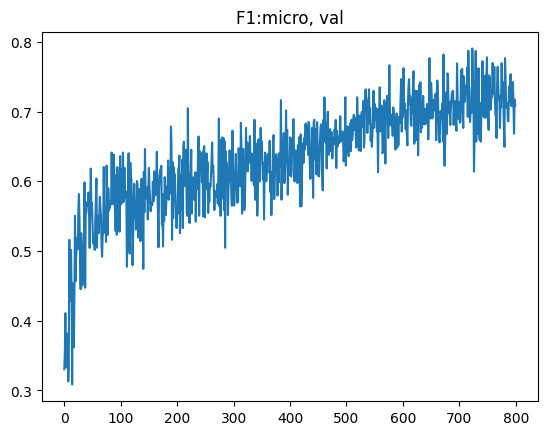

In [92]:
plt.plot(accuracy_history)
plt.title('F1:micro, val')

Text(0.5, 1.0, 'loss_history, train')

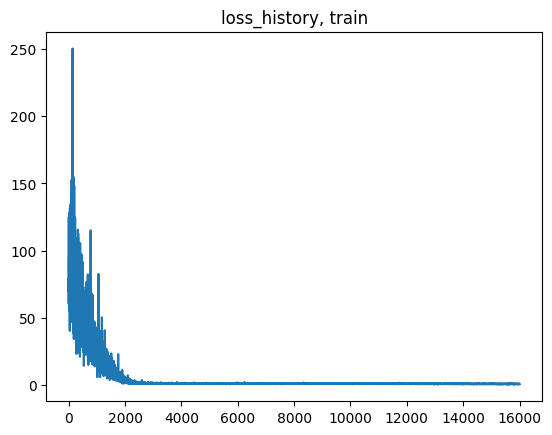

In [93]:
plt.plot(loss_history)
plt.title('loss_history, train')

In [94]:
torch.save(last_good_model, 'model1.pth')
# Model(feature_size = feat_size, emb_size = 8, hid_size = 128)
best_acc 

0.790625

In [95]:
test_loader = DataLoader(dataset=HorseDataset('test', res_test), batch_size=1, shuffle=False)
model = Model(feature_size = feat_size, emb_size = 8, hid_size = 128).to(device)
model.load_state_dict(last_good_model)
model.eval()

res = []

for batch_data in tqdm(test_loader):
    with torch.no_grad():
        logits = model(batch_data)
    label = logits.argmax(dim=1).detach().cpu().numpy()
    res.append(label[0])
 

  0%|          | 0/824 [00:00<?, ?it/s]

In [96]:
sample_df['outcome'] = label_enc2.inverse_transform(res)
sample_df.to_csv('submission.csv', index=False)

Best score on test: 0.75

## 4. Advanced

It chapter below I'll try to do something non-trivial

In [97]:
train_df = pd.read_csv('/kaggle/input/playground-series-s3e22/train.csv')
test_df = pd.read_csv('/kaggle/input/playground-series-s3e22/test.csv')
sample_df = pd.read_csv('/kaggle/input/playground-series-s3e22/sample_submission.csv')
original_df = pd.read_csv('/kaggle/input/horse-survival-dataset/horse.csv')

train_df =  train_df.drop(['id'], axis=1)
test_df = test_df.drop(['id'], axis=1)
original_df = original_df[train_df.columns]

train_df['generated'] = True
original_df['generated'] = False
test_df['generated'] = True

train_df['generated'] = train_df['generated'].astype(object)
original_df['generated'] = original_df['generated'].astype(object)
test_df['generated'] = test_df['generated'].astype(object)

new_train_df = pd.concat([train_df, original_df]).sample(frac=1)


new_train_df['pain']=new_train_df['pain'].replace('slight','mild_pain')
test_df['pain']=test_df['pain'].replace('moderate','mild_pain')

new_train_df['peristalsis']=new_train_df['peristalsis'].replace('distend_small','hypermotile')
new_train_df['nasogastric_reflux']=new_train_df['nasogastric_reflux'].replace('slight','less_1_liter')
new_train_df['rectal_exam_feces']=new_train_df['rectal_exam_feces'].replace('serosanguious','increased')

## 4.1. Missing values

Let's have a closer look to missing values

In [98]:
train_distribution_of_nans_per_row = list(new_train_df.isna().sum(axis=1))
test_distribution_of_nans_per_row = test_df.isna().sum(axis=1)

Text(0.5, 1.0, 'Distribution of count of nans per row in train')

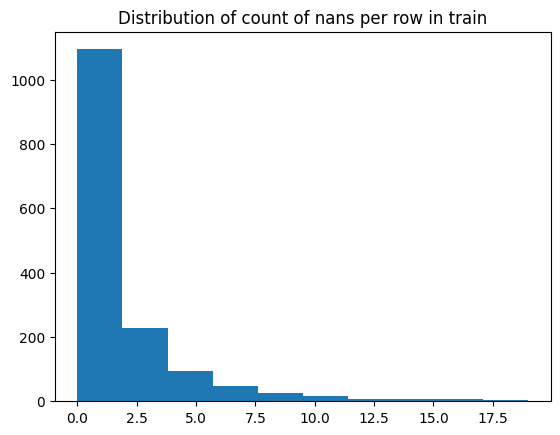

In [99]:
plt.hist(new_train_df.isna().sum(axis=1))
plt.title('Distribution of count of nans per row in train')

Text(0.5, 1.0, 'Distribution of count of nans per row in test')

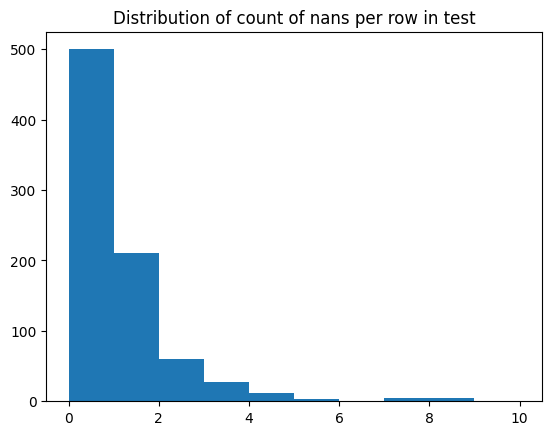

In [100]:
plt.hist(test_df.isna().sum(axis=1))
plt.title('Distribution of count of nans per row in test')

In [101]:
np.percentile(list(new_train_df.isna().sum(axis=1)), q=97.5)

10.0

97.5% of train data has less than 10 nans. Let's remove all rows with >10 nans

In [102]:
train_df = new_train_df[new_train_df.isna().sum(axis=1) <= 10]

In [103]:
train_df.loc[:,'hospital_number'] = train_df['hospital_number'].astype('object')
test_df.loc[:,'hospital_number'] = test_df['hospital_number'].astype('object')

Now we fill missing values by **predicting**. We can use Knn (`sklearn.impute.KNNImputer`) or `sklearn.impute.IterativeImputer` with CatBoostRegression & Classification

Well, Im kinda new to this api, so I had problems using IterativeImputer with CatBoost. It supposed to be something like that:

In [104]:
# from sklearn.experimental import enable_iterative_imputer
# from sklearn.impute import IterativeImputer

# df = pd.concat([train_df, test_df], axis=0)
# df = df.reset_index(drop=True)
# df['hospital_number'] = df['hospital_number'].astype('object')

# cat_feat_idxs = []
# for i, col in enumerate(df).dtypes):
#     if col == 'object':
#         cat_feat_idxs.append(i)
        
# cat_params={# ...
# }

# estimator = cb.CatBoostClassifier(verbose=False, cat_features=cat_feat_idxs,**cat_params)

# imputer = IterativeImputer(estimator=estimator)
# imputer.fit(df)

But it seems like it still cant process categorical features. I guess Im doing something wrong, so I'll have to implement `imputer` by my own.

Actually I'll use code of this smart guy as a base. I'll edit since I want to try an other logic

https://www.kaggle.com/code/arunklenin/ps3e15-iterative-catboost-imputer-ensemble

https://www.kaggle.com/code/arunklenin/advanced-feature-engg-techniques-beyond-basics/notebook#4.-Handle-Missing-Values

In [105]:
cb_clf_params ={'iterations' : 250,
            'max_depth': 8,
            'learning_rate': 0.1,
            'l2_leaf_reg': 0.7,
            'random_strength': 0.2,
            'max_bin': 200,
            'od_wait': 35,
            'one_hot_max_size': 70,
            'od_type': 'Iter',
            'eval_metric': 'MultiClass',
            'loss_function': 'MultiClass',
}

cb_reg_params = {
            'iterations': 250,
            'depth': 6,
            'learning_rate': 0.02,
            'l2_leaf_reg': 0.5,
            'random_strength': 0.2,
            'max_bin': 150,
            'od_wait': 40,
            'one_hot_max_size': 70,
            'od_type': 'IncToDec',
            'eval_metric': 'RMSE',
            'loss_function': 'RMSE',
            'random_state': 42,
        }

In [106]:
# Returns dict {'name of feature having nans': indeces of rows with this feature = nan'}
    
def store_missing_rows(df, features):
    missing_rows = {}
    
    for feature in features:
        missing_rows[feature] = df[df[feature].isnull()].index
    
    return missing_rows

In [107]:
# Function for parsing randomed index. Returns name of feature and type
def get_feature(cat_features, num_features, idx):
    if (len(cat_features) < len(num_features)):
        if idx >= len(cat_features):
            return num_features[idx - len(cat_features)], 'num'
        else:
            return cat_features[idx], 'cat'
    else:
        if idx < len(num_features):
            return num_features[idx], 'num'
        else:
            return cat_features[idx - len(num_features)], 'cat'

In [108]:
def iterative_imputer(train, test, target, cb_clf_params, 
                      cb_reg_params, max_iterations=10):
    catboost_classifier = cb.CatBoostClassifier(**cb_clf_params)
    catboost_regressor = cb.CatBoostRegressor(**cb_reg_params)
    
    df = pd.concat([train.drop(columns=target), test], axis=0)
    df = df.reset_index(drop=True)
    
    miss_cat_features=[f for f in df.columns if df[f].dtype=="O" and df[f].isna().sum()>0]
    miss_num_features=[f for f in df.columns if df[f].dtype !="O" and df[f].isna().sum()>0]

    
    cat_features_all=[f for f in df.columns if df[f].dtype=="O"]
    dictionary = defaultdict(list)

    missing_rows = store_missing_rows(df, miss_cat_features + miss_num_features)
    
    # Initially filling all missing values
    for f in miss_cat_features:
        df[f] = df[f].fillna(df[f].mode()[0])
        
    for f in miss_num_features:
        df[f]=df[f].fillna(df[f].mean())
        
    for iteration in tqdm(range(max_iterations), desc="Iterations"):
        sequence_of_features = np.random.choice(len(miss_cat_features) + len(miss_num_features),
                         replace=False, size=len(miss_cat_features) + len(miss_num_features))
        
        

        for idx in tqdm(sequence_of_features, desc='Features'):
            feature, type_ = get_feature(miss_cat_features, miss_num_features, idx)
            
            rows_miss = missing_rows[feature]
            missing_temp = df.loc[rows_miss].copy() # data for predict
            if type_ == 'num':
                y_pred_prev=missing_temp[feature]
                
            non_missing_temp = df.drop(index=rows_miss).copy() # data for fit
            missing_temp = missing_temp.drop(columns=[feature])

            
            X_train = non_missing_temp.drop(columns=[feature])
            y_train = non_missing_temp[[feature]]

            if type_ == 'cat':          
                other_features = [x for x in df.columns if x != feature and df[x].dtype == "O"]
                catboost_classifier.fit(X_train, y_train, cat_features=other_features, verbose=False)
                y_pred = catboost_classifier.predict(missing_temp)
                if y_pred.dtype != "O":
                    y_pred = y_pred.astype(str)
                df.loc[rows_miss, feature] = y_pred
                
                
            if type_ == 'num':
                catboost_regressor.fit(X_train, y_train,cat_features=cat_features_all, verbose=False)
                y_pred = catboost_regressor.predict(missing_temp)
                df.loc[rows_miss, feature] = y_pred
                error_minimize=mean_squared_error(y_pred,y_pred_prev, squared=False)
                dictionary[feature].append(error_minimize)  # Append the error_minimize value

    for feature, values in dictionary.items():
        iterations = range(1, len(values) + 1)  # x-axis values (iterations)
        plt.plot(iterations, values, label=feature)  # plot the values
        plt.xlabel('Iterations')
        plt.ylabel('RMSE')
        plt.title('Minimization of RMSE with iterations')
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()
    
    train.loc[:, miss_cat_features + miss_num_features] = np.array(
        df.iloc[:train.shape[0]][miss_cat_features + miss_num_features])
    test.loc[:, miss_cat_features + miss_num_features] = np.array(
        df.iloc[train.shape[0]:][miss_cat_features + miss_num_features])

    return train, test     

Pipeline:

1. We get all names of features, which have nans. Also for every feature we know which raws have Nan as this feature. These raws are the data we are predicting for, Train data - raws without Nans in this specific feature
2. Initial filling: mode for categorical, median for numeric
3. Repeat k times: get random feature's order. For each feature we fit catboost estimator to predict nans, predict nans on test and apply changes to data. So at the next itetation we won't have nans, but for fit we'll use updated data, having our predicted values. The idea is that iterations must converge. Plotting error for numeric features should show it

Iterations:   0%|          | 0/10 [00:00<?, ?it/s]

Features:   0%|          | 0/19 [00:00<?, ?it/s]

Features:   0%|          | 0/19 [00:00<?, ?it/s]

Features:   0%|          | 0/19 [00:00<?, ?it/s]

Features:   0%|          | 0/19 [00:00<?, ?it/s]

Features:   0%|          | 0/19 [00:00<?, ?it/s]

Features:   0%|          | 0/19 [00:00<?, ?it/s]

Features:   0%|          | 0/19 [00:00<?, ?it/s]

Features:   0%|          | 0/19 [00:00<?, ?it/s]

Features:   0%|          | 0/19 [00:00<?, ?it/s]

Features:   0%|          | 0/19 [00:00<?, ?it/s]

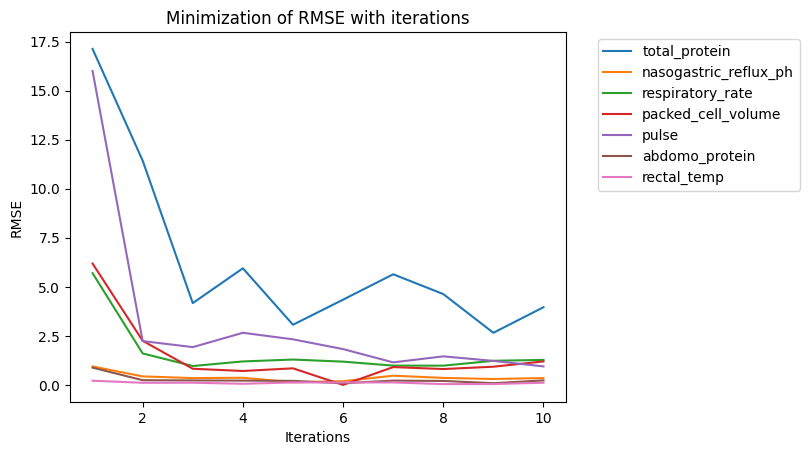

In [109]:
train, test = iterative_imputer(train_df.copy(), test_df.copy(), 'outcome', cb_clf_params, 
                      cb_reg_params, max_iterations=10)

## 4.2. Feature Engineering

Ideas:
1. Try diffrent scalings to numeric data (StandartScaler, MinMax, PowerTransformer e.t.c). Probably add pca(1) of them
2. Add some numeric charasteristics of categorial features (e.g. total number of this categorical value, e.t.c)
3. Add some categorical charasteristics of numeric features (we can binarize numeric data)
4. Add some preprocessing.PolynomialFeatures
5. Somehow find out which features of them are top-k best and use them in future 

**None of code below helped, so for finaly submission it is not used**

In [110]:
last_train = train.copy()
last_test = test.copy()

In [111]:
train = last_train.copy()
test = last_test.copy()

Let's check for significant relationship with the target

In [112]:
def chi_squared_test(df, input_var, target_var, significance_level=0.05):
    contingency_table = pd.crosstab(df[input_var], df[target_var])
    chi2, p, _, _ = stats.chi2_contingency(contingency_table)
    
    if p < significance_level:
        print(f'\033[32m{input_var} has a significant relationship with the target variable.\n.\033[0m', end=' ')
        print(f'P-value is {p :.8f}')
        
    else:
        print(f'\033[31m{input_var} does not have a significant relationship with the target variable.\033[0m', end=' ')  
        print(f'P-value is {p :.3f}')

In [113]:
cat_feats = [train.columns[i] for i, typee in enumerate(train.dtypes) if typee == object]
cat_feats.append('lesion_3') # lesion_3 has only 2 values

In [114]:
for i in cat_feats:
    chi_squared_test(train, i,'outcome')

surgery has a significant relationship with the target variable.
. P-value is 0.00000000
age has a significant relationship with the target variable.
. P-value is 0.00000000
hospital_number has a significant relationship with the target variable.
. P-value is 0.00000000
temp_of_extremities has a significant relationship with the target variable.
. P-value is 0.00000000
peripheral_pulse has a significant relationship with the target variable.
. P-value is 0.00000000
mucous_membrane has a significant relationship with the target variable.
. P-value is 0.00000000
capillary_refill_time has a significant relationship with the target variable.
. P-value is 0.00000000
pain has a significant relationship with the target variable.
. P-value is 0.00000000
peristalsis has a significant relationship with the target variable.
. P-value is 0.00000000
abdominal_distention has a significant relationship with the target variable.
. P-value is 0.00000000
nasogastric_tube has a significant relationship w

So we drop lesion_3

In [115]:
train = train.drop(['lesion_3'], axis=1)
test = test.drop(['lesion_3'], axis=1)

Scaling is not really necessary for boosting, but we still do it

In [116]:
# scaler = StandardScaler()
# numeric_feat = train.columns[[i for i, x in enumerate(train.columns) 
#                                  if train[x].dtype == "int" or train[x].dtype == "float"]]

# scaler.fit(train[numeric_feat])

# train[numeric_feat] = scaler.transform(train[numeric_feat])
# test[numeric_feat] = scaler.transform(test[numeric_feat])

Add polynomial data

In [117]:
numeric_feat = train.columns[[i for i, x in enumerate(train.columns) 
                                 if train[x].dtype == "int" or train[x].dtype == "float"]]
poly = PolynomialFeatures(degree=3, include_bias=True)
poly.fit(train[numeric_feat])

PolynomialFeatures(degree=3)

In [118]:
trans_train = poly.transform(train[numeric_feat])
trainpd = pd.DataFrame(trans_train[:, len(numeric_feat):])

In [119]:
trainpd.index = train.index
train = pd.concat([train, trainpd], axis=1)

trans_test = poly.transform(test[numeric_feat])
testpd = pd.DataFrame(trans_test[:, len(numeric_feat):])
testpd.index = test.index

test = pd.concat([test, testpd], axis=1)

In [120]:
train.columns = train.columns.astype(str)
test.columns = test.columns.astype(str)

Let's leave only important features

In [121]:
cb_clf_params ={'iterations' : 800,
            'max_depth': 8,
            'learning_rate': 0.1,
            'l2_leaf_reg': 0.7,
            'random_strength': 0.2,
            'max_bin': 200,
            'od_wait': 35,
            'one_hot_max_size': 70,
            'od_type': 'Iter',
            'eval_metric': 'TotalF1:average=Micro',
            'loss_function': 'MultiClass',
}

In [122]:
cv_dataset = cb.Pool(data=train.drop(['outcome'], axis=1),
                  label=train['outcome'],
                  cat_features=[x for x in train.columns if train[x].dtype == 'object' and x!= 'outcome'])

In [123]:
(cv_results, fitted_models)  = cb.cv(cv_dataset,
            cb_clf_params,
            fold_count=4, 
            logging_level='Silent', return_models=True)

In [124]:
cv_results

iterations  test-TotalF1:average=Micro-mean  \
0             0                         0.650707   
1             1                         0.657360   
2             2                         0.650037   
3             3                         0.673995   
4             4                         0.666670   
..          ...                              ...   
140         140                         0.708590   
141         141                         0.708590   
142         142                         0.708590   
143         143                         0.709255   
144         144                         0.709920   

     test-TotalF1:average=Micro-std  train-TotalF1:average=Micro-mean  \
0                          0.010999                          0.734530   
1                          0.022551                          0.767353   
2                          0.012603                          0.783100   
3                          0.019881                          0.786425   
4                          0.015610                          0.788422   
..                              ...                               ...   
140                        0.014284                          0.961637   
141                        0.014284                          0.961637   
142                        0.014284                          0.961637   
143                        0.014921                          0.961637   
144                        0.015646                          0.961637   

     train-TotalF1:average=Micro-std  test-MultiClass-mean  \
0                           0.012464              1.041174   
1                           0.006942              0.997877   
2                           0.003999              0.962243   
3                           0.007402              0.931033   
4                           0.004720              0.904584   
..                               ...                   ...   
140                         0.027871              0.672865   
141                         0.027871              0.672783   
142                         0.027871              0.672608   
143                         0.027871              0.672777   
144                         0.027871              0.672851   

     test-MultiClass-std  train-MultiClass-mean  train-MultiClass-std  
0               0.002306               1.026425              0.003018  
1               0.003431               0.965876              0.001465  
2               0.003792               0.914423              0.001964  
3               0.005092               0.872228              0.003464  
4               0.004167               0.833513              0.002358  
..                   ...                    ...                   ...  
140             0.018540               0.259919              0.096479  
141             0.018628               0.259766              0.096770  
142             0.018818               0.259637              0.097017  
143             0.018634               0.259321              0.097618  
144             0.018556               0.259105              0.098031  

[145 rows x 9 columns]

Text(0.5, 1.0, 'Feature Importance')

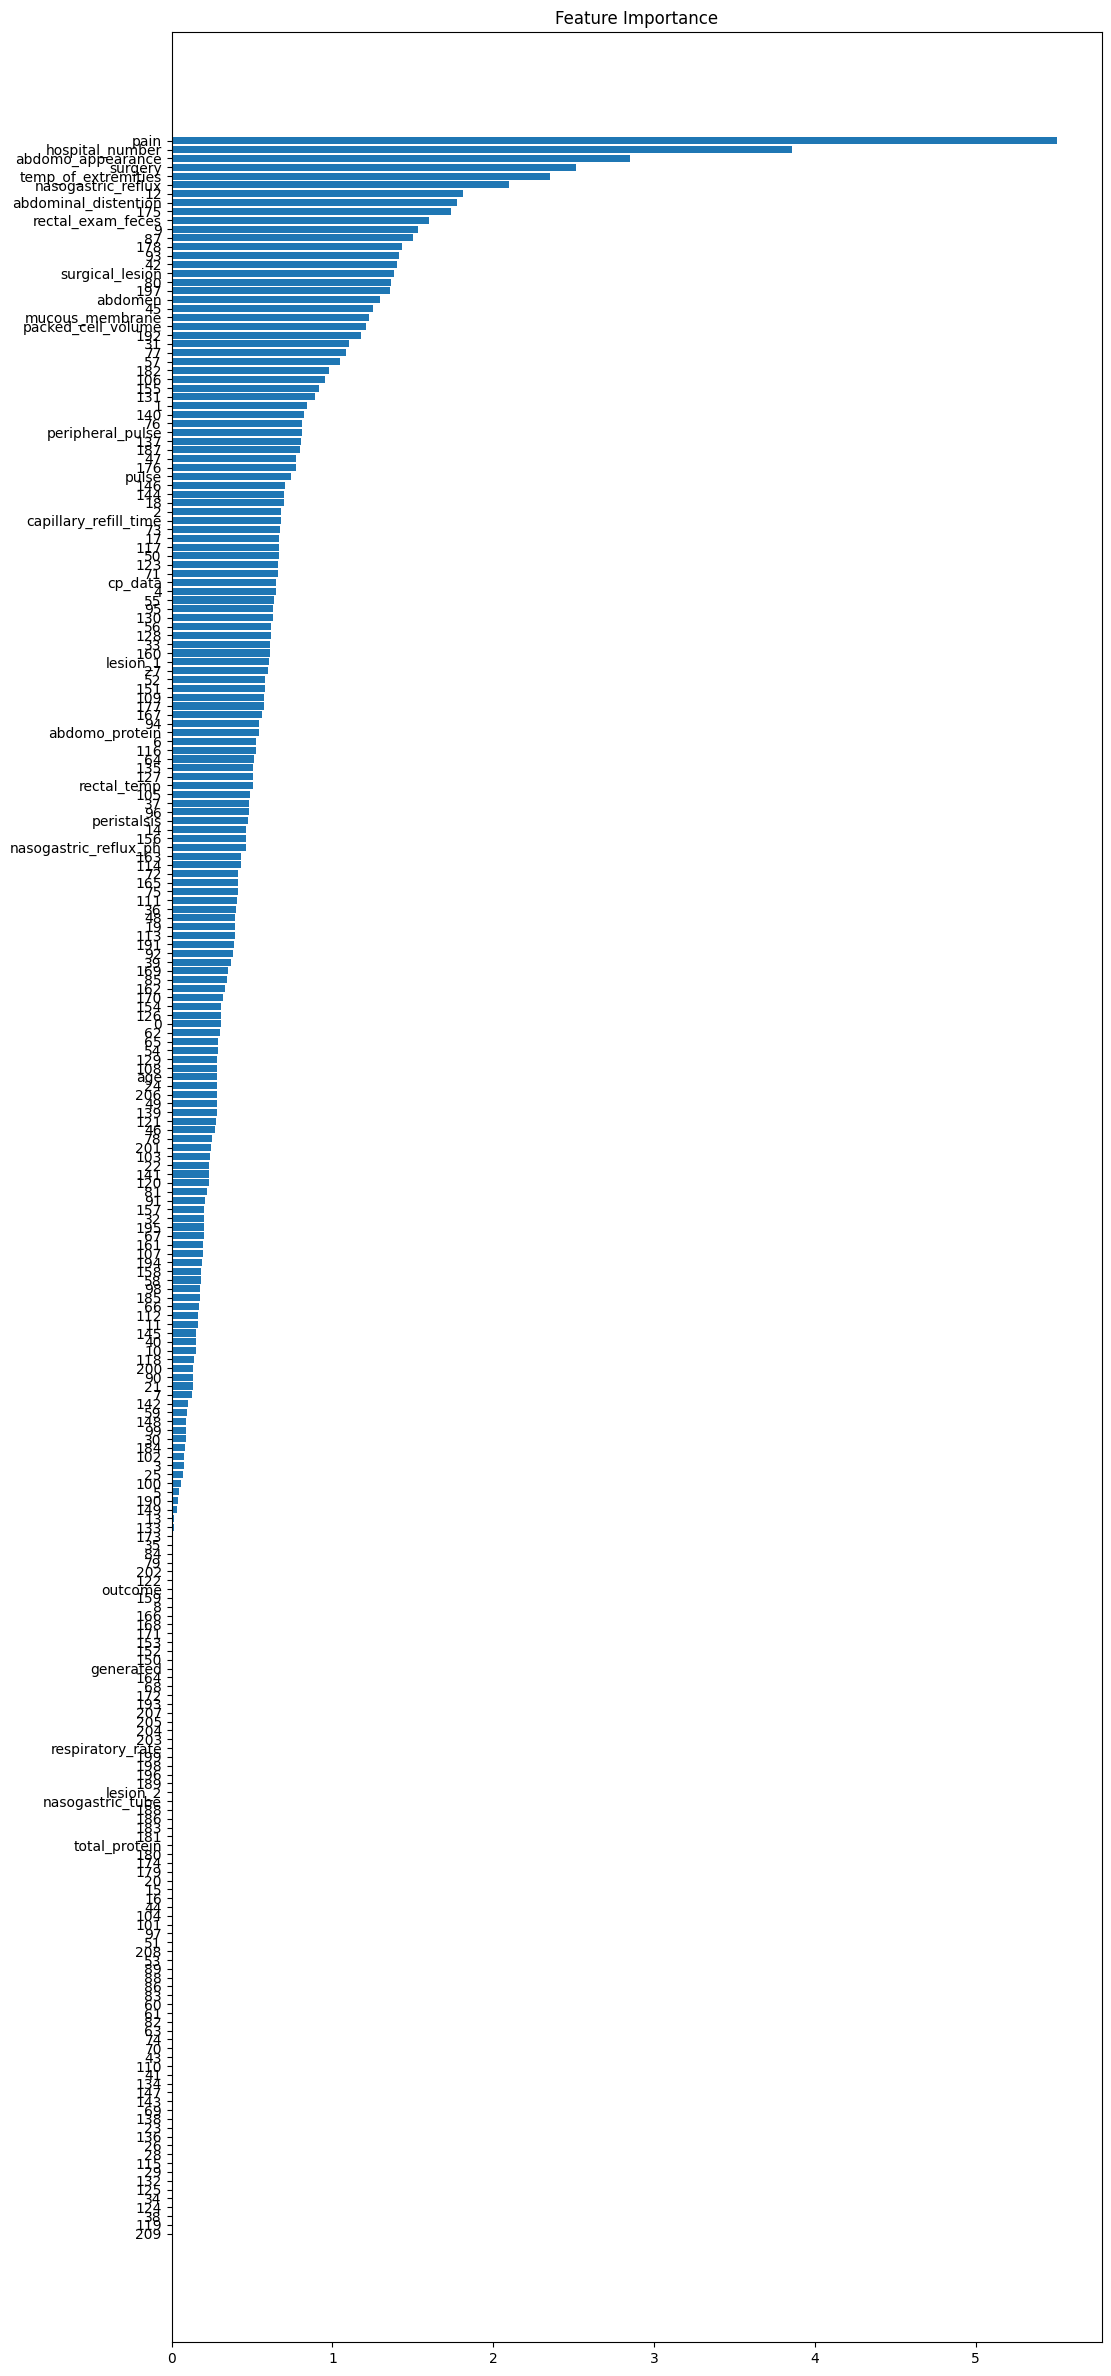

In [125]:
feature_importance = fitted_models[0].get_feature_importance()
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 30))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(train.columns)[sorted_idx])
plt.title('Feature Importance')


Actually, good way to check if feature is important is to use `permutation_importance`. For each column it shuffles values in this column and checks how did the metric change. Simple and smart

As we result of catboost.cv we get cb.CatBoost model, which, unfortunately, returns probabilities as the result of `.predict`. So we need to write custom scoring function

In [126]:
def catboost_sucks(y, y_pred):
    return f1_score(y, y_pred.argmax(axis=1), average='micro')

Text(0.5, 1.0, 'Permutation Importance')

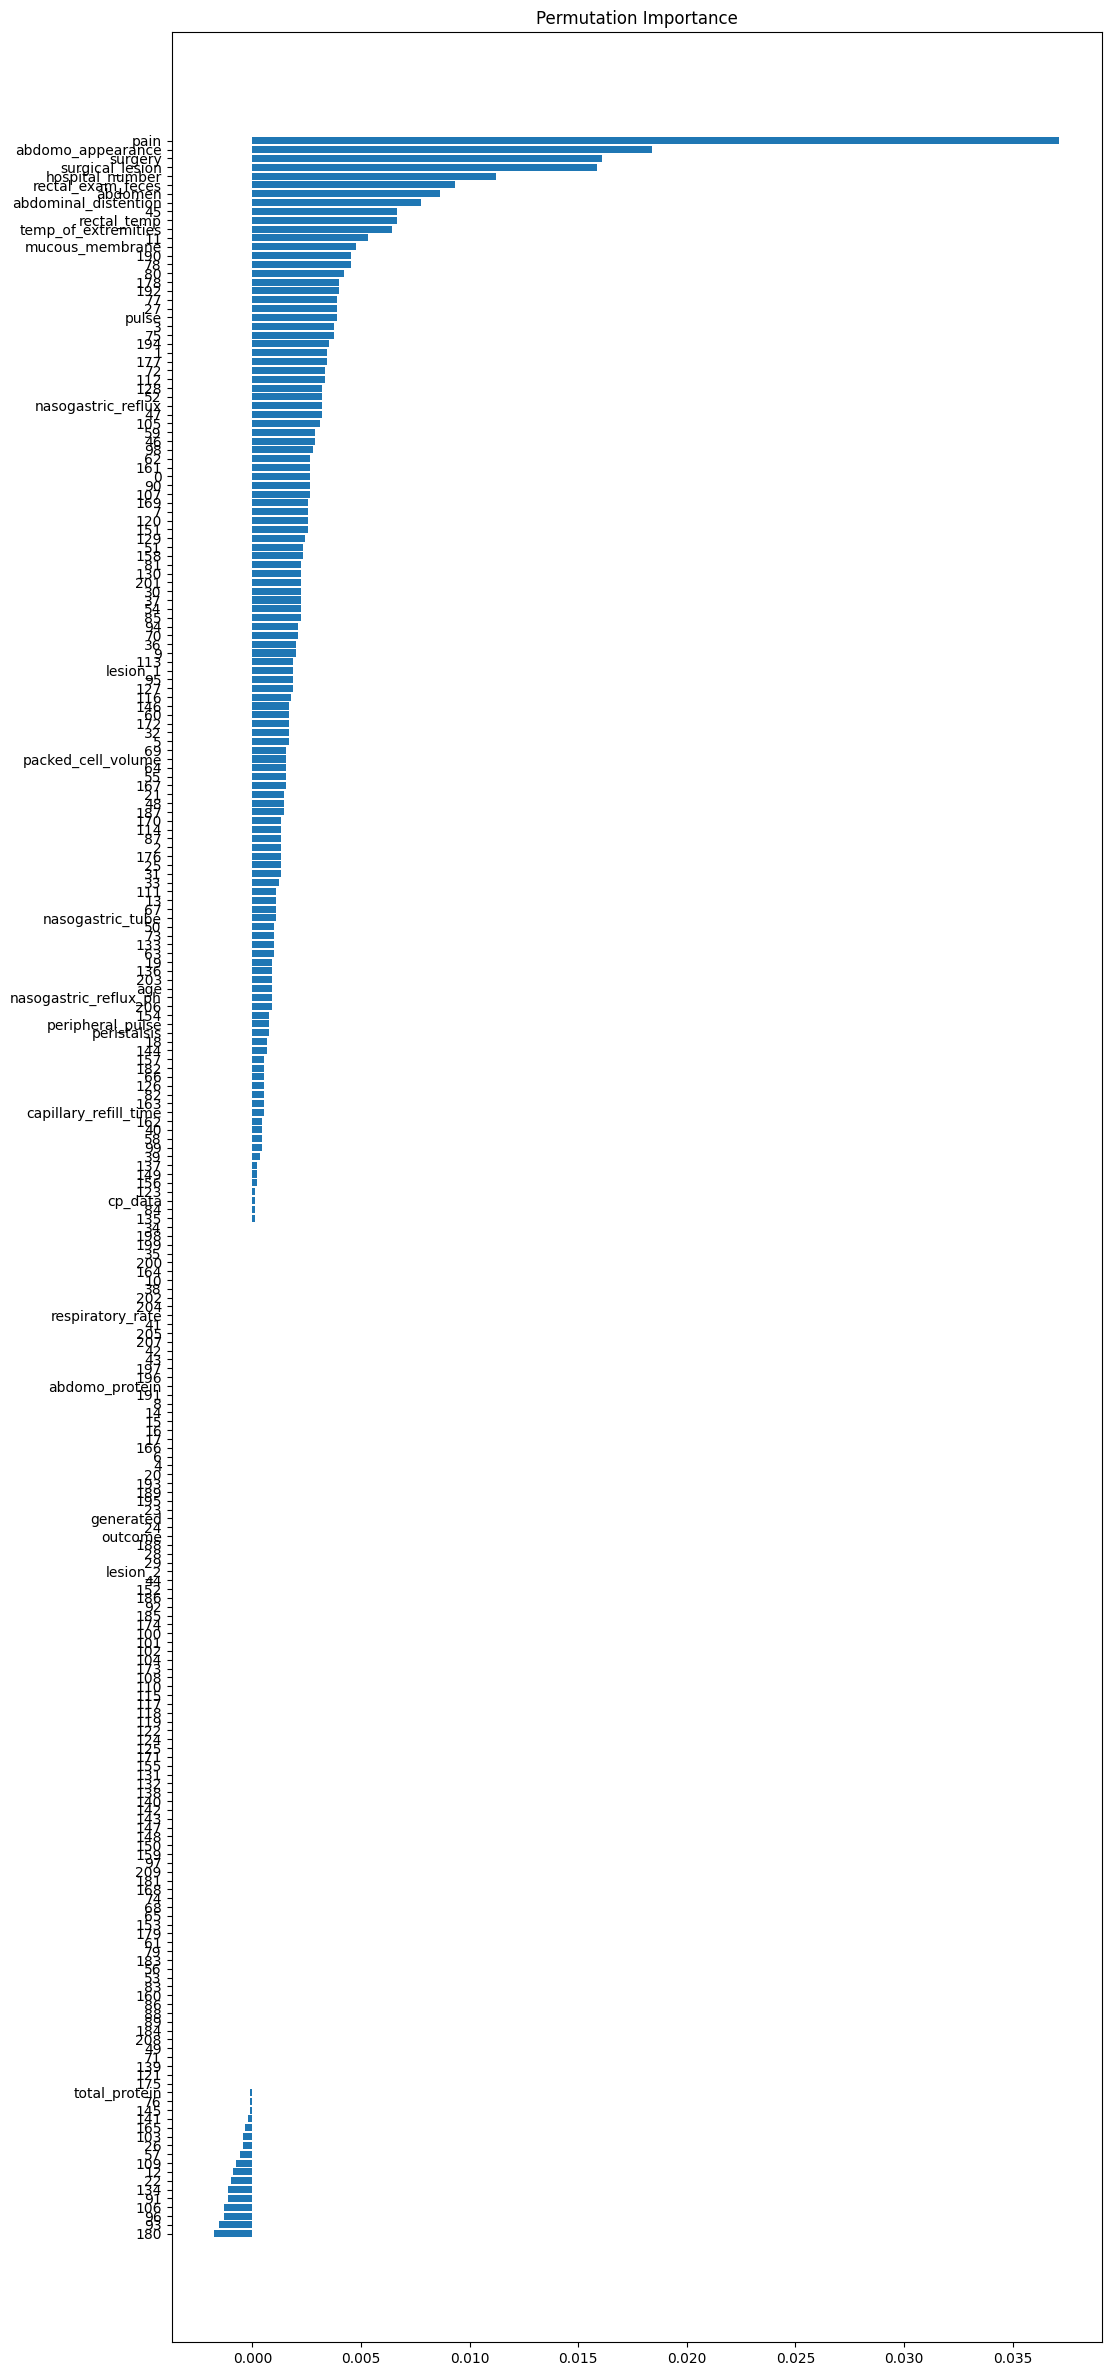

In [127]:
perm_importance = permutation_importance(fitted_models[3], train.drop(['outcome'], axis=1),
                                         LabelEncoder().fit_transform(train['outcome']), scoring=make_scorer(catboost_sucks),
                                         n_repeats=6, random_state=1066)
sorted_idx = perm_importance.importances_mean.argsort()
fig = plt.figure(figsize=(12, 30))
plt.barh(range(len(sorted_idx)), perm_importance.importances_mean[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(train.columns)[sorted_idx])
plt.title('Permutation Importance')


In [128]:
important_features = np.array(test.columns)[perm_importance.importances_mean > 
                                            np.percentile(perm_importance.importances_mean, q=80)]
important_features

array(['surgery', 'hospital_number', 'rectal_temp', 'pulse',
       'temp_of_extremities', 'mucous_membrane', 'pain',
       'abdominal_distention', 'nasogastric_reflux', 'rectal_exam_feces',
       'abdomen', 'abdomo_appearance', 'surgical_lesion', '1', '2', '4',
       '8', '12', '28', '46', '47', '48', '52', '53', '60', '63', '73',
       '76', '78', '79', '81', '91', '99', '106', '108', '113', '121',
       '129', '130', '152', '159', '162', '170', '178', '179', '191',
       '193', '195'], dtype=object)

In [129]:
test = test[important_features]
train = train[list(important_features) + ['outcome']]

## 4.3. Ensemble of models aka `Stacking`

Good guide tho
https://www.kaggle.com/code/arthurtok/introduction-to-ensembling-stacking-in-python#Ensembling-&-Stacking-models

Briefly, what we need for stacking:

0. Perhaps we have train and test data
1. Use kfold cv for train.
2. For each model we fit model on (n-1) folds and predict on 1 fold. Predicted values have same shape as train.shape[0] tho. If we concat predicted values of all models in ensemble, these values are new features for meta-model. Our train data has shape `[train.shape[0], num of models]`. Just learned this is called `Out of Fold`
3. As for predicted values, it can be number for regression, class or logits for classification
4. Meta-model can be boosting, neural network, logistic regression etc
5. What about test data? We have 2 options here:
6. Fisrt. When we fit estimator on (n-1) folds, we can predict values for test_set. The issue is that as a result of kfold-cv we have `n * test.shape[0]` predictions. We can chose those of them, which was gotten from estimator with the best validation score. Or we can take mean of them. Also we save estimators which had best validation score for futher work with new test data
7. Second. At first we save best estimator for each model and then do predict and construct dataset for meta model

In [130]:
# Class to extend the classifiers
class Classifier(object):
    def __init__(self, clf, proba = True, params=None):
        self.proba = proba
        self.clf = clf(**params)

    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)
    
    def predict(self, x):
        if self.proba == True:
            return self.clf.predict_proba(x)
        else:
            return self.clf.predict(x)
    
    def fit(self,x,y):
        return self.clf.fit(x,y)
    
    def feature_importances(self):
        return self.clf.feature_importances_

Fucntion for forming train and test data for meta-model

In [131]:
# Using global NFOLDS and kf
NFOLDS = 5
kf = KFold(n_splits= NFOLDS)

def out_of_fold(clf, x_train, y_train, x_test, proba=True):
    if proba == True:
        oof_train = np.zeros((x_train.shape[0], 3))
        oof_test = np.zeros((x_test.shape[0], 3))
        oof_test_skf = np.empty((NFOLDS, x_test.shape[0], 3))
    else:
        oof_train = np.zeros((x_train.shape[0], ))
        oof_test = np.zeros((x_test.shape[0], ))
        oof_test_skf = np.empty((NFOLDS, x_test.shape[0], ))
    best_validation_score = 0
    best_estimator = None

    for i, (train_index, test_index) in enumerate(kf.split(x_train.index)):
        x_tr = x_train.loc[x_train.index[train_index]]
        y_tr = y_train.loc[y_train.index[train_index]]
        x_te = x_train.loc[x_train.index[test_index]]
        y_te = y_train.loc[y_train.index[test_index]]

        clf.train(x_tr, y_tr)        
        y_pred = clf.predict(x_te)
        if proba == True:
            val_score = f1_score(y_te, y_pred.argmax(axis=1), average='micro')
        else:
            val_score = f1_score(y_te, y_pred.ravel(), average='micro')
            
        if val_score > best_validation_score:
            best_validation_score = val_score
            best_estimator = clf.clf
            
        if proba == True:
            oof_train[y_train.index[test_index]] = y_pred
            oof_test_skf[i, :] = clf.predict(x_test)
        else:
            oof_train[y_train.index[test_index]] = y_pred.ravel()
            oof_test_skf[i, :] = clf.predict(x_test).ravel()

    
    clf.clf = best_estimator
    if proba == True:
        oof_test[:] = oof_test_skf.mean(axis=0)
        return oof_train, oof_test
    else:
        # Code for getting most frequent class among 0 axis
        axis=0
        u, indices = np.unique(oof_test_skf, return_inverse=True)
        oof_test = u[np.argmax(np.apply_along_axis(np.bincount, axis, indices.reshape(oof_test_skf.shape),
                                None, np.max(indices) + 1), axis=axis)]
        return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1)

### Making data for different models

#### 1. Data for models which can process categorical features

In [132]:
target_map={
    "lived":0,
    "died": 1,
    "euthanized":2
}  
# .reset_index(drop=True)
X = train.drop(['outcome'], axis=1).reset_index(drop=True)
y = train['outcome']
y = y.replace(target_map).reset_index(drop=True)

for col in X.columns:
    if X[col].dtype == object:
        X[col] = X[col].astype('category')
        
X_test = test.copy()
for col in X_test.columns:
    if X_test[col].dtype == object:
        X_test[col] = X_test[col].astype('category')

ALso, after we removed some "sparse" rows (which had a lot of nans) from train, our test data now has some values which train does not have. Let's mark them with another category = 0

In [133]:
missing = [x for x in X_test['hospital_number'] if x not in X['hospital_number'].values]
idxs =np.where(X_test['hospital_number'].isin(missing).values)
missing, idxs

([5277409, 528338, 5279441, 5281091], (array([399, 558, 606, 659]),))

In [134]:
X_test['hospital_number'] = X_test['hospital_number'].astype('int')
X_test.loc[idxs[0], 'hospital_number'] = list(X_test.loc[idxs[0], 'hospital_number'].apply(lambda x: 0))
X_test['hospital_number'] = X_test['hospital_number'].astype('category')
X_test.loc[idxs[0]]

surgery hospital_number  rectal_temp  pulse temp_of_extremities  \
399     yes               0         39.1  164.0                cold   
558      no               0         38.1   88.0                cool   
606     yes               0         38.5   60.0              normal   
659     yes               0         37.5   52.0                cool   

    mucous_membrane       pain abdominal_distention nasogastric_reflux  \
399   dark_cyanotic  depressed             moderate       less_1_liter   
558   pale_cyanotic  mild_pain             moderate       less_1_liter   
606       pale_pink  mild_pain             moderate       more_1_liter   
659       pale_pink  mild_pain             moderate               none   

    rectal_exam_feces  ...      130          152        159     162      170  \
399         decreased  ...  50803.2  409522176.0   55200.00  1728.0  140.450   
558            absent  ...   3400.0   39200000.0   59150.00  2762.5  104.000   
606            absent  ...   1008.0   58397232.0  114359.04  2520.0   18.432   
659            normal  ...   9600.0  195010560.0   19872.00   630.0   38.880   

         178        179      191        193      195  
399  12211.2  5087232.0  373.248  114462.72  202.248  
558  10000.0  3500000.0  614.125  101150.00  136.000  
606   4000.0  5515000.0  343.000  108094.00   17.920  
659   4410.0  2704800.0  216.000   79488.00   77.760  

[4 rows x 48 columns]

#### 2. Data for models which do not support categorial features

There is a **crutch**: test data has some values which are not in train, as we said above. So we marked all the new data with 0. But One Hot Encoding still does not know about `0`-data, so we'll use some of test data for learning OHE

In [135]:
categorical_features_to_one_hot = [x for x in X.columns if X[x].dtype == 'category']

onehot = OneHotEncoder(drop='first') # good for logistic regression
onehot.fit(pd.concat([X, X_test.loc[idxs[0]]], axis=0)[categorical_features_to_one_hot]) # this is a crutch
onehot_encoded = onehot.transform(X[categorical_features_to_one_hot])

onehot_encoded_df_train = pd.DataFrame(onehot_encoded.toarray(), columns=
                                 onehot.get_feature_names_out(onehot.feature_names_in_))


numeric_df_train = X.iloc[:, ~X.columns.isin(categorical_features_to_one_hot)]

onehot_encoded_df_train.index = numeric_df_train.index
X_cat_train = pd.concat([onehot_encoded_df_train, numeric_df_train], axis=1)

onehot_encoded = onehot.transform(X_test[categorical_features_to_one_hot])

onehot_encoded_df_train = pd.DataFrame(onehot_encoded.toarray(), columns=
                                 onehot.get_feature_names_out(onehot.feature_names_in_))


numeric_df_train = X_test.iloc[:, ~X_test.columns.isin(categorical_features_to_one_hot)]

onehot_encoded_df_train.index = numeric_df_train.index
X_cat_test = pd.concat([onehot_encoded_df_train, numeric_df_train], axis=1)


#### 3. Data for HistGradientClassifier

HistGradientBoostingClassifier supports categorical features, but needs categorical data as int, so we need yet again make data. We'll use Label encoder

In [136]:
X2 = X.copy()
X_test2 = X_test.copy()
le = LabelEncoder()
df = pd.concat([X2, X_test2.loc[idxs[0]]], axis=0)
for col in X2.columns[[i for i, x in enumerate(X2.columns) 
                                 if X2[x].dtype == "category"]]:
    le.fit(df[col])
    X2[col] = le.transform(X2[col])
    X_test2[col] = le.transform(X_test2[col])

Also HistGradientBoostingClassifier has a limit of 255 categorical values for a feature. `hospital number` has 278. So we need to one hot this column

In [137]:
onehot = OneHotEncoder(drop='first')
onehot.fit(pd.concat([X2, X_test2.loc[idxs[0]]], axis=0)['hospital_number'].values.reshape(-1, 1))

OneHotEncoder(drop='first')

In [138]:
encoded_train = onehot.transform(X2['hospital_number'].values.reshape(-1, 1))
encoded_test = onehot.transform(X_test2['hospital_number'].values.reshape(-1, 1))


onehot_encoded_df_train = pd.DataFrame(encoded_train.toarray(), columns=
                                 onehot.get_feature_names_out())


numeric_df_train = X2.drop(['hospital_number'], axis=1)

onehot_encoded_df_train.index = numeric_df_train.index
X2 = pd.concat([onehot_encoded_df_train, numeric_df_train], axis=1)


onehot_encoded_df_test = pd.DataFrame(encoded_test.toarray(), columns=
                                 onehot.get_feature_names_out())


numeric_df_test = X_test2.drop(['hospital_number'], axis=1)

onehot_encoded_df_test.index = numeric_df_test.index
X_test2 = pd.concat([onehot_encoded_df_test, numeric_df_test], axis=1)


#### 4. Data for logistic regression

For logistic regresseion we need to do standartization

In [139]:
scaler = StandardScaler()
X_cat_train2 = X_cat_train.copy()
X_cat_test2 = X_cat_test.copy()

numeric_feat = X2.loc[:, [x for i, x in enumerate(X.columns) 
                                 if X[x].dtype != "category"]].columns

scaler.fit(X_cat_train2[numeric_feat])

X_cat_train2[numeric_feat] = scaler.transform(X_cat_train2[numeric_feat])
X_cat_test2[numeric_feat] = scaler.transform(X_cat_test2[numeric_feat])

### Finally, Stacking!

In [140]:
config = {
    
    'logreg': {'max_iter': 1000},
    
    'xgb': {
    'n_estimators': 500,
    'max_depth': 7,
    'enable_categorical': True,
    'tree_method':"hist",
    'objective': 'binary:logistic'
    },
    
    'lgb': {
    'n_estimators': 500,
    'max_depth': 7,
    'learning_rate': 0.05,
    'subsample': 0.20,
    'colsample_bytree': 0.56,
    'reg_alpha': 0.25,
    'reg_lambda': 5e-08,
    'boosting_type': 'gbdt',
    },
    
    'cb' : {
    'iterations': 500,
    'depth': 7,
    'learning_rate': 0.1,
    'l2_leaf_reg': 0.7,
    'random_strength': 0.2,
    'max_bin': 200,
    'od_wait': 65,
    'one_hot_max_size': 70,
    'grow_policy': 'Depthwise',
    'bootstrap_type': 'Bayesian',
    'od_type': 'Iter',
    'loss_function' : 'MultiClass',
    'verbose': False,
    'cat_features': [i for i, x in enumerate(X.columns) if X[x].dtype == "category"]
    },
    
    'gaus': {'kernel':1.0 * RBF(1.0)},
    
    'rf': {'n_estimators':300,
            'max_depth' : 50},
    'hgb' : {'max_iter':500,
             'max_depth': 6,
             'categorical_features': X.columns[[i for i, x in enumerate(X.columns) 
                                                if X[x].dtype == "category" and x != 'hospital_number']]},
    'gb': {'n_estimators':400,
             'max_depth': 6},
    
    'brf': {'n_estimators':300,
             'max_depth': 50,
             'sampling_strategy':'all',
             'replacement' : True},
    
    'ada': {'n_estimators':500},
    
    'extra': {'n_estimators':300,
             'max_depth': 50},
    
    'svc': {'gamma': 'auto',
             'probability': True},
    
    'knn':{'n_neighbors': 30},
    
    'mlp': {'max_iter': 600}
}

In [141]:
#using global data (X, y, X_test, X_cat.....)
def construct_data_for_meta_model(config, proba=False):    
    logreg_cl = Classifier(clf = LogisticRegression, proba=proba, params = config['logreg'])
    xgb_cl = Classifier(clf=XGBClassifier, proba=proba, params=config['xgb'])
    lgb_cl = Classifier(clf=lgb.LGBMClassifier, proba=proba, params=config['lgb'])
    cb_cl = Classifier(clf=cb.CatBoostClassifier, proba=proba, params=config['cb'])
    gaus_cl = Classifier(clf = GaussianProcessClassifier, proba=proba, params = config['gaus'])
    rf_cl = Classifier(clf = RandomForestClassifier, proba=proba, params = config['rf'])
    hgb_cl = Classifier(clf = HistGradientBoostingClassifier, proba=proba, params = config['hgb'])
    gb_cl = Classifier(clf = GradientBoostingClassifier, proba=proba, params = config['gb'])
    brf_cl = Classifier(clf = BalancedRandomForestClassifier, proba=proba, params = config['brf'])
    ada_cl = Classifier(clf = AdaBoostClassifier, proba=proba, params = config['ada'])
    extra_cl = Classifier(clf = ExtraTreesClassifier, proba=proba, params = config['extra'])
    svc_cl = Classifier(clf = SVC, proba=proba, params = config['svc'])
    knn_cl = Classifier(clf = KNeighborsClassifier, proba=proba, params = config['knn'])
    mlp_cl = Classifier(clf = MLPClassifier, proba=proba, params = config['mlp'])
    
    
    # 1. sklearn LogisticRegression
    logreg_oof_train, logreg_oof_test = out_of_fold(logreg_cl, X_cat_train2, y, X_cat_test2, proba=proba)
    print('LogisticRegression done')
    
    # 2. XGBOOST
    
    xgb_oof_train, xgb_oof_test = out_of_fold(xgb_cl, X, y, X_test, proba=proba)
    print('Xgboost done')
    
    # 3. lightgbm
    
    lgb_oof_train, lgb_oof_test = out_of_fold(lgb_cl, X, y, X_test, proba=proba)
    print('Lightgbm done')
    
    # 4. catboost
    cb_oof_train, cb_oof_test = out_of_fold(cb_cl, X, y, X_test, proba=proba)
    print('Catboost done')
    
    # 5. sklearn GaussianProcessClassifier
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        gaus_oof_train, gaus_oof_test = out_of_fold(gaus_cl, X_cat_train, y, X_cat_test, proba=proba)
    print('GaussianProcess done')
    
    # 6. sklearn.randomforest   
    rf_oof_train, rf_oof_test = out_of_fold(rf_cl, X_cat_train, y, X_cat_test, proba=proba)
    print('RandomForest done')
    
    # 7. sklearn HistGradientBoosting
    hgb_oof_train, hgb_oof_test = out_of_fold(hgb_cl, X2, y, X_test2, proba=proba)
    print('HistGradientBoosting done')
    
    # 8. sklearn GradientBoosting
    gb_oof_train, gb_oof_test = out_of_fold(gb_cl, X_cat_train, y, X_cat_test, proba=proba)
    print('GradientBoosting done')
    
    # 9. imblearn BalancedRandomForestClassifier 
    brf_oof_train, brf_oof_test = out_of_fold(brf_cl, X_cat_train, y, X_cat_test, proba=proba)
    print('BalancedRandomForest done')
    
    # 10. sklearn AdaBoostClassifier
    ada_oof_train, ada_oof_test = out_of_fold(ada_cl, X_cat_train, y, X_cat_test, proba=proba)
    print('AdaBoost done')
    
    # 11. sklearn ExtraTreesClassifier   
    extra_oof_train, extra_oof_test = out_of_fold(extra_cl, X_cat_train, y, X_cat_test, proba=proba)
    print('ExtraTrees done')    
    
    # 12. sklearn Support vector machine
    svc_oof_train, svc_oof_test = out_of_fold(svc_cl, X_cat_train, y, X_cat_test, proba=proba)
    print('SVM done')
    
    # 13. sklearn KNeighborsClassifier
    knn_oof_train, knn_oof_test = out_of_fold(knn_cl, X_cat_train2, y, X_cat_test2, proba=proba)
    print('KNN done')
    
    # 14. sklearn MLPClassifier    
    mlp_oof_train, mlp_oof_test = out_of_fold(mlp_cl, X_cat_train, y, X_cat_test, proba=proba)
    print('MLP done')
    
    
    
    
    meta_train_x = np.stack([logreg_oof_train, xgb_oof_train, lgb_oof_train, 
                             cb_oof_train, gaus_oof_train, rf_oof_train, 
                             hgb_oof_train, gb_oof_train, brf_oof_train,
                             ada_oof_train, extra_oof_train, svc_oof_train,
                             knn_oof_train, mlp_oof_train], axis=-1)
    
    meta_train_x = meta_train_x.reshape(meta_train_x.shape[0], -1)

    meta_test_x = np.stack([logreg_oof_test, xgb_oof_test, lgb_oof_test,
                            cb_oof_test, gaus_oof_test, rf_oof_test,
                            hgb_oof_test, gb_oof_test, brf_oof_test, 
                            ada_oof_test, extra_oof_test, svc_oof_test, 
                            knn_oof_test, mlp_oof_test], axis=-1)

    meta_test_x = meta_test_x.reshape(meta_test_x.shape[0], -1)
    
    return meta_train_x, meta_test_x
    

In [142]:
meta_train_x, meta_test_x = construct_data_for_meta_model(config, proba=True)

LogisticRegression done
Xgboost done
Lightgbm done
Catboost done
GaussianProcess done
RandomForest done
HistGradientBoosting done
GradientBoosting done
BalancedRandomForest done
AdaBoost done
ExtraTrees done
SVM done
KNN done
MLP done


In [143]:
meta_train_x.shape, meta_test_x.shape, 

((1503, 42), (824, 42))

Hyperparams tuning with GridSearch (would be better to use Optima):

In [144]:
clf = cb.CatBoostClassifier(loss_function='MultiClass', 
                            eval_metric = 'TotalF1:average=Micro',
                            verbose=0,
                            learning_rate = 0.05)

grid = {'max_depth': [4, 6], 'n_estimators':[300, 450, 600],
                                'random_strength' : [0.2, 0.5],
#                                 bagging_temperature = 0.7,
#                                 border_count = 30,
                                'l2_leaf_reg': [1, 5],
         }

clf_grid = GridSearchCV(estimator=clf, param_grid=grid, scoring='f1_micro', cv=5, verbose=1, refit=True)

In [145]:
clf_grid.fit(meta_train_x, y)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


GridSearchCV(cv=5,
             estimator=<catboost.core.CatBoostClassifier object at 0x7f54ba2e9330>,
             param_grid={'l2_leaf_reg': [1, 5], 'max_depth': [4, 6],
                         'n_estimators': [300, 450, 600],
                         'random_strength': [0.2, 0.5]},
             scoring='f1_micro', verbose=1)

In [146]:
pd.DataFrame(clf_grid.cv_results_).sort_values(by=['mean_test_score'], ascending=False).loc[5]

mean_fit_time                                                     3.468748
std_fit_time                                                      0.049387
mean_score_time                                                   0.006087
std_score_time                                                    0.000145
param_l2_leaf_reg                                                        1
param_max_depth                                                          4
param_n_estimators                                                     600
param_random_strength                                                  0.5
params                   {'l2_leaf_reg': 1, 'max_depth': 4, 'n_estimato...
split0_test_score                                                 0.724252
split1_test_score                                                 0.727575
split2_test_score                                                 0.710963
split3_test_score                                                 0.746667
split4_test_score        

In [147]:
pd.DataFrame(clf_grid.cv_results_).sort_values(by=['mean_test_score'], ascending=False).head(5)

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
22      11.408110      0.375107         0.006231        0.000164   
20       8.680760      0.370836         0.007053        0.002320   
14       2.846300      0.331582         0.005923        0.000108   
18       5.922971      0.237997         0.005906        0.000119   
19       5.845015      0.233932         0.007194        0.002664   

   param_l2_leaf_reg param_max_depth param_n_estimators param_random_strength  \
22                 5               6                600                   0.2   
20                 5               6                450                   0.2   
14                 5               4                450                   0.2   
18                 5               6                300                   0.2   
19                 5               6                300                   0.5   

                                               params  split0_test_score  \
22  {'l2_leaf_reg': 5, 'max_depth': 6, 'n_estimato...           0.737542   
20  {'l2_leaf_reg': 5, 'max_depth': 6, 'n_estimato...           0.737542   
14  {'l2_leaf_reg': 5, 'max_depth': 4, 'n_estimato...           0.737542   
18  {'l2_leaf_reg': 5, 'max_depth': 6, 'n_estimato...           0.734219   
19  {'l2_leaf_reg': 5, 'max_depth': 6, 'n_estimato...           0.740864   

    split1_test_score  split2_test_score  split3_test_score  \
22           0.760797           0.717608           0.756667   
20           0.744186           0.720930           0.750000   
14           0.747508           0.714286           0.733333   
18           0.747508           0.720930           0.746667   
19           0.744186           0.710963           0.733333   

    split4_test_score  mean_test_score  std_test_score  rank_test_score  
22           0.736667         0.741856        0.015567                1  
20           0.736667         0.737865        0.009752                2  
14           0.753333         0.737200        0.013466                3  
18           0.730000         0.735865        0.010123                4  
19           0.743333         0.734536        0.012391                5

In [148]:
answers = clf_grid.best_estimator_.predict(meta_test_x)

Text(0.5, 1.0, 'Feature importances')

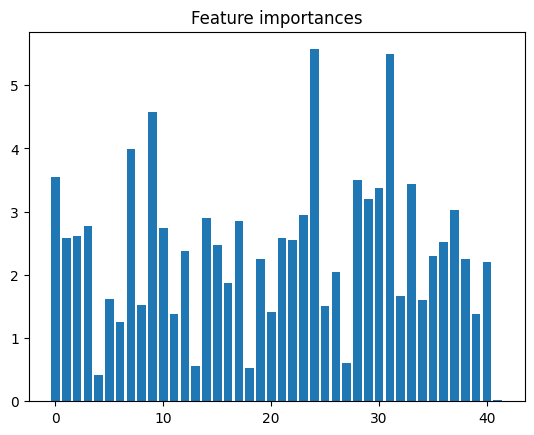

In [149]:
plt.bar(x=range(meta_train_x.shape[1]),height=clf_grid.best_estimator_.feature_importances_)
plt.title('Feature importances')

In [150]:
np.argsort(clf_grid.best_estimator_.feature_importances_)[::-1]

array([24, 31,  9,  7,  0, 28, 33, 30, 29, 37, 23, 14, 17,  3, 10,  2, 21,
        1, 22, 36, 15, 12, 35, 19, 38, 40, 26, 16, 32,  5, 34,  8, 25, 20,
       11, 39,  6, 27, 13, 18,  4, 41])

In [151]:
top3 = np.argsort(clf_grid.best_estimator_.feature_importances_)[::-1][:3]
indeces_of_important = top3 // 3
print('3 most important models in ensemble')
[list(config.keys())[i] for i in indeces_of_important]

3 most important models in ensemble


['brf', 'extra', 'cb']

In [152]:
sample_df['outcome'] = answers.flatten()
sample_df['outcome'] = sample_df['outcome'].replace({v:k for k,v in target_map.items()})
sample_df.to_csv('sample_submission.csv', index=False)

In [153]:
sample_df

id     outcome
0    1235       lived
1    1236        died
2    1237       lived
3    1238  euthanized
4    1239       lived
..    ...         ...
819  2054        died
820  2055  euthanized
821  2056        died
822  2057       lived
823  2058       lived

[824 rows x 2 columns]

Models predict classes, not probabilities [Didnt improve]

In [154]:
meta_train_x, meta_test_x = construct_data_for_meta_model(config, proba=False)

LogisticRegression done
Xgboost done
Lightgbm done
Catboost done
GaussianProcess done
RandomForest done
HistGradientBoosting done
GradientBoosting done
BalancedRandomForest done
AdaBoost done
ExtraTrees done
SVM done
KNN done
MLP done


In [155]:
meta_train_x.shape, meta_test_x.shape

((1503, 14), (824, 14))

In [156]:
clf = cb.CatBoostClassifier(loss_function='MultiClass', 
                            eval_metric = 'TotalF1:average=Micro',
                            verbose=0,
                            learning_rate = 0.05)

grid = {'max_depth': [5, 7], 'n_estimators':[300, 400],
                                'random_strength' : [0.2],
#                                 bagging_temperature = 0.7,
#                                 border_count = 30,
#                                 l2_leaf_reg = 5,
         }

clf_grid = GridSearchCV(estimator=clf, param_grid=grid, scoring='f1_micro', cv=5, verbose=1)

In [157]:
clf_grid.fit(meta_train_x, y)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


GridSearchCV(cv=5,
             estimator=<catboost.core.CatBoostClassifier object at 0x7f54be1883d0>,
             param_grid={'max_depth': [5, 7], 'n_estimators': [300, 400],
                         'random_strength': [0.2]},
             scoring='f1_micro', verbose=1)

In [158]:
pd.DataFrame(clf_grid.cv_results_).sort_values(by=['mean_test_score'], ascending=False).head(5)

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       0.355670      0.039773         0.003495        0.000191   
1       0.605925      0.203112         0.004188        0.000941   
2       0.440992      0.012238         0.003641        0.000170   
3       0.554524      0.003343         0.003722        0.000072   

  param_max_depth param_n_estimators param_random_strength  \
0               5                300                   0.2   
1               5                400                   0.2   
2               7                300                   0.2   
3               7                400                   0.2   

                                              params  split0_test_score  \
0  {'max_depth': 5, 'n_estimators': 300, 'random_...           0.724252   
1  {'max_depth': 5, 'n_estimators': 400, 'random_...           0.727575   
2  {'max_depth': 7, 'n_estimators': 300, 'random_...           0.727575   
3  {'max_depth': 7, 'n_estimators': 400, 'random_...           0.717608   

   split1_test_score  split2_test_score  split3_test_score  split4_test_score  \
0           0.734219           0.707641           0.706667           0.740000   
1           0.730897           0.697674           0.710000           0.726667   
2           0.714286           0.687708           0.723333           0.736667   
3           0.704319           0.684385           0.713333           0.733333   

   mean_test_score  std_test_score  rank_test_score  
0         0.722556        0.013551                1  
1         0.718563        0.012717                2  
2         0.717914        0.016733                3  
3         0.710596        0.016125                4

In [159]:
answers = clf_grid.best_estimator_.predict(meta_test_x)
sample_df['outcome'] = answers.flatten()
sample_df['outcome'] = sample_df['outcome'].replace({v:k for k,v in target_map.items()})
sample_df.to_csv('sample_submission2.csv', index=False)